In [1]:
import json

with open('./_vg_85_bgg5jsons 2/0/30_cl.json') as f:
    templates = json.load(f)

# print(templates)
templates['cargo_space']
templates.keys()

dict_keys(['put_cargos', 'cargo_space', 'cargo_groups', 'timeout_params', 'calculation_params'])

In [8]:
templates['put_cargos']

[]

In [15]:
templates['cargo_groups']

[{'id': '12043Y1',
  'mass': 1832,
  'size': [230, 230, 380],
  'sort': 1,
  'count': 1,
  'stacking': True,
  'turnover': False,
  'overhang_angle': 50,
  'stacking_limit': 0,
  'stacking_is_limited': False,
  'group_id': '4561038K1'},
 {'id': '12040Y1',
  'mass': 1086,
  'size': [360, 205, 170],
  'sort': 2,
  'count': 1,
  'stacking': True,
  'turnover': False,
  'overhang_angle': 50,
  'stacking_limit': 0,
  'stacking_is_limited': False,
  'group_id': '1008702I3'},
 {'id': '12036Y1',
  'mass': 5330,
  'size': [420, 298, 420],
  'sort': 3,
  'count': 1,
  'stacking': True,
  'turnover': False,
  'overhang_angle': 50,
  'stacking_limit': 0,
  'stacking_is_limited': False,
  'group_id': '2688101L5'},
 {'id': '12008Y1',
  'mass': 3057,
  'size': [410, 166, 200],
  'sort': 4,
  'count': 1,
  'stacking': True,
  'turnover': False,
  'overhang_angle': 50,
  'stacking_limit': 0,
  'stacking_is_limited': False,
  'group_id': '3030110W8'},
 {'id': '11033Y1',
  'mass': 1140,
  'size': [380, 1

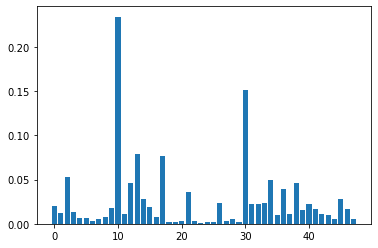

In [67]:

import matplotlib.pylab as plt



In [ ]:

import json

with open('./_vg_85_bgg5jsons 2/0/30_cl.json') as f:
    templates = json.load(f)


plt.savefig('foo.png')

In [17]:
mass = 0
for i in templates['cargo_groups']:
    mass += i['mass']*i['count']
mass

71000

In [10]:
templates['cargo_space']

{'id': 794381,
 'mass': 20,
 'size': [1250, 2100, 1800],
 'params': {'protrusion': [50, 50], 'indentation': [50, 50]},
 'carrying_capacity': 800}

In [21]:
templates['cargo_space']['size'][0]*templates['cargo_space']['size'][1]*templates['cargo_space']['size'][2]/1000000000

4.725

In [22]:
templates['cargo_space']['size'][0]*templates['cargo_space']['size'][1]/1000000

2.625

In [11]:
templates['timeout_params']

{'timeout': 600}

In [7]:
templates['calculation_params']

{'calculation_id': 508708, 'accounting_center_of_mass': 0}

In [8]:
list(templates.keys())[0]

{'id': 0, 'height': 10, 'width': 20, 'length': 30, 'weight': 5}

In [25]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
class Rectangle:
    
    def __init__(self, xcenter, ycenter, length, width):
        self.xc = xcenter
        self.yc = ycenter
        self.length = length
        self.width = width
        self.lx = xcenter - length/2
        self.ly = ycenter + width/2
        self.rx = xcenter + length/2
        self.ry = ycenter -width/2
        
    def fromleftdown(self, lx, ly, length, width):
        self.lx = lx 
        self.ly = ly + width
        self.rx = lx + length
        self.ry = ly - width
        
# Returns true if two rectangles(l1, r1)
# and (l2, r2) overlap
def doOverlap(l1, r1, l2, r2):
     
    # if rectangle has area 0, no overlap
    if (l1.x == r1.x or l1.y == r1.y or r2.x == l2.x or l2.y == r2.y):
        return False
     
    # If one rectangle is on left side of other
    if(l1.x > r2.x or l2.x > r1.x):
        return False
 
    # If one rectangle is above other
    if(r1.y > l2.y or r2.y > l1.y):
        return False
 
    return True
 
l1 = Point(0, 10)
r1 = Point(10, 0)
l2 = Point(5, 5)    
r2 = Point(15, 0)
if(doOverlap(l1, r1, l2, r2)):
    print("Rectangles Overlap")
else:
    print("Rectangles Don't Overlap")
 


Rectangles Overlap


In [52]:
from datetime import datetime
import time

In [55]:
import numpy as np

box = templates['cargo_groups'][0]
print(box['size'])

a = np.zeros(templates['cargo_space']['size'], dtype = np.int8)
start_time = datetime.now()
# a[0]
for i in range(box['size'][0]):
    for j in range(box['size'][1]):
        for k in range(box['size'][2]):
            a[k][i][j] = 1
print(datetime.now() - start_time)

[230, 230, 380]
0:00:08.296211


In [51]:
a[227:231,227:231, 227:231]

array([[[1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 0, 0]],

       [[1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 0, 0]],

       [[1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 0, 0]],

       [[1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 0, 0]]], dtype=int8)

In [93]:
import os

# with open(file_name, 'wt') as f:
#     f.write('example file')

# print('Cleaning up')
# os.unlink(file_name)
# os.rmdir(dir_name)
import os.path
for address, dirs, files in os.walk('./_vg_85_bgg5jsons 2/'):
    
    for name in files:
        print(os.path.join(address, name))
        pa = os.path.join(address, name)

./_vg_85_bgg5jsons 2/.DS_Store
./_vg_85_bgg5jsons 2/138000/138740_cl.json
./_vg_85_bgg5jsons 2/138000/138732_cl.json
./_vg_85_bgg5jsons 2/138000/138986_cl.json
./_vg_85_bgg5jsons 2/138000/138177_cl.json
./_vg_85_bgg5jsons 2/138000/138868_cl.json
./_vg_85_bgg5jsons 2/138000/138653_cl.json
./_vg_85_bgg5jsons 2/138000/138643_cl.json
./_vg_85_bgg5jsons 2/138000/138462_cl.json
./_vg_85_bgg5jsons 2/138000/138766_cl.json
./_vg_85_bgg5jsons 2/138000/138371_cl.json
./_vg_85_bgg5jsons 2/138000/138017_cl.json
./_vg_85_bgg5jsons 2/138000/138007_cl.json
./_vg_85_bgg5jsons 2/138000/138715_cl.json
./_vg_85_bgg5jsons 2/138000/138411_cl.json
./_vg_85_bgg5jsons 2/138000/138569_cl.json
./_vg_85_bgg5jsons 2/138000/138378_cl.json
./_vg_85_bgg5jsons 2/138000/138182_cl.json
./_vg_85_bgg5jsons 2/138000/138189_cl.json
./_vg_85_bgg5jsons 2/138000/138174_cl.json
./_vg_85_bgg5jsons 2/138000/138202_cl.json
./_vg_85_bgg5jsons 2/138000/138596_cl.json
./_vg_85_bgg5jsons 2/138000/138826_cl.json
./_vg_85_bgg5jsons 2/13

./_vg_85_bgg5jsons 2/136000/136423_cl.json
./_vg_85_bgg5jsons 2/136000/136889_cl.json
./_vg_85_bgg5jsons 2/136000/136727_cl.json
./_vg_85_bgg5jsons 2/136000/136204_cl.json
./_vg_85_bgg5jsons 2/136000/136388_cl.json
./_vg_85_bgg5jsons 2/136000/136398_cl.json
./_vg_85_bgg5jsons 2/136000/136013_cl.json
./_vg_85_bgg5jsons 2/136000/136003_cl.json
./_vg_85_bgg5jsons 2/136000/136317_cl.json
./_vg_85_bgg5jsons 2/136000/136095_cl.json
./_vg_85_bgg5jsons 2/136000/136232_cl.json
./_vg_85_bgg5jsons 2/136000/136773_cl.json
./_vg_85_bgg5jsons 2/136000/136405_cl.json
./_vg_85_bgg5jsons 2/136000/136002_cl.json
./_vg_85_bgg5jsons 2/136000/136012_cl.json
./_vg_85_bgg5jsons 2/136000/136306_cl.json
./_vg_85_bgg5jsons 2/136000/136881_cl.json
./_vg_85_bgg5jsons 2/136000/136422_cl.json
./_vg_85_bgg5jsons 2/136000/136853_cl.json
./_vg_85_bgg5jsons 2/136000/136163_cl.json
./_vg_85_bgg5jsons 2/136000/136914_cl.json
./_vg_85_bgg5jsons 2/136000/136062_cl.json
./_vg_85_bgg5jsons 2/136000/136243_cl.json
./_vg_85_bg

./_vg_85_bgg5jsons 2/124000/124421_cl.json
./_vg_85_bgg5jsons 2/124000/124351_cl.json
./_vg_85_bgg5jsons 2/124000/124724_cl.json
./_vg_85_bgg5jsons 2/124000/124442_cl.json
./_vg_85_bgg5jsons 2/124000/124851_cl.json
./_vg_85_bgg5jsons 2/124000/124366_cl.json
./_vg_85_bgg5jsons 2/124000/124231_cl.json
./_vg_85_bgg5jsons 2/124000/124613_cl.json
./_vg_85_bgg5jsons 2/124000/124647_cl.json
./_vg_85_bgg5jsons 2/124000/124118_cl.json
./_vg_85_bgg5jsons 2/124000/124155_cl.json
./_vg_85_bgg5jsons 2/124000/124307_cl.json
./_vg_85_bgg5jsons 2/124000/124951_cl.json
./_vg_85_bgg5jsons 2/124000/124839_cl.json
./_vg_85_bgg5jsons 2/124000/124679_cl.json
./_vg_85_bgg5jsons 2/124000/124889_cl.json
./_vg_85_bgg5jsons 2/124000/124539_cl.json
./_vg_85_bgg5jsons 2/124000/124398_cl.json
./_vg_85_bgg5jsons 2/124000/124353_cl.json
./_vg_85_bgg5jsons 2/141000/141023_cl.json
./_vg_85_bgg5jsons 2/141000/141017_cl.json
./_vg_85_bgg5jsons 2/141000/141038_cl.json
./_vg_85_bgg5jsons 2/141000/141006_cl.json
./_vg_85_bg

./_vg_85_bgg5jsons 2/12000/12182_cl.json
./_vg_85_bgg5jsons 2/12000/12963_cl.json
./_vg_85_bgg5jsons 2/12000/12901_cl.json
./_vg_85_bgg5jsons 2/12000/12594_cl.json
./_vg_85_bgg5jsons 2/12000/12445_cl.json
./_vg_85_bgg5jsons 2/12000/12419_cl.json
./_vg_85_bgg5jsons 2/12000/12665_cl.json
./_vg_85_bgg5jsons 2/12000/12356_cl.json
./_vg_85_bgg5jsons 2/12000/12503_cl.json
./_vg_85_bgg5jsons 2/12000/12369_cl.json
./_vg_85_bgg5jsons 2/12000/12871_cl.json
./_vg_85_bgg5jsons 2/12000/12039_cl.json
./_vg_85_bgg5jsons 2/12000/12621_cl.json
./_vg_85_bgg5jsons 2/12000/12759_cl.json
./_vg_85_bgg5jsons 2/12000/12547_cl.json
./_vg_85_bgg5jsons 2/12000/12312_cl.json
./_vg_85_bgg5jsons 2/12000/12285_cl.json
./_vg_85_bgg5jsons 2/12000/12563_cl.json
./_vg_85_bgg5jsons 2/12000/12191_cl.json
./_vg_85_bgg5jsons 2/12000/12648_cl.json
./_vg_85_bgg5jsons 2/12000/12213_cl.json
./_vg_85_bgg5jsons 2/12000/12683_cl.json
./_vg_85_bgg5jsons 2/12000/12107_cl.json
./_vg_85_bgg5jsons 2/12000/12198_cl.json
./_vg_85_bgg5jso

In [100]:


for address, dirs, files in os.walk('./_vg_85_bgg5jsons 2/'):
    
    for name in files:
        print(os.path.join(address, name))
        pa = os.path.join(address, name)
        if(pa ==  './_vg_85_bgg5jsons 2/.DS_Store'):
            continue
        else:
            with open(pa) as f:
                templates = json.load(f)
                
            volume = {}
            print(templates['cargo_groups'][0]['size'])
            if(isinstance(templates['cargo_groups'][0]['size'], dict)):
                for j,i in enumerate(templates['cargo_groups']):
                    volume[j] = i['size']['width']*i['size']['height']*i['size']['length']/1000000000
                
                
            else:
                for j,i in enumerate(templates['cargo_groups']):
                    volume[j] = i['size'][0]*i['size'][1]*i['size'][2]/1000000000
                
            lists = sorted(volume.items())
            x, y = zip(*lists) 
            plt.bar(x, y)
            plt.savefig('./test_dir/'+name.split('.')[0]+'.png')
            plt.clf()
            plt.close()
            f.close()
        
    

./_vg_85_bgg5jsons 2/.DS_Store
./_vg_85_bgg5jsons 2/138000/138740_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/138000/138732_cl.json
{'width': 210, 'height': 162, 'length': 210}
./_vg_85_bgg5jsons 2/138000/138986_cl.json
{'width': 150, 'height': 340, 'length': 130}
./_vg_85_bgg5jsons 2/138000/138177_cl.json
{'width': 260, 'height': 228, 'length': 190}
./_vg_85_bgg5jsons 2/138000/138868_cl.json
{'width': 270, 'height': 92, 'length': 350}
./_vg_85_bgg5jsons 2/138000/138653_cl.json
{'width': 170, 'height': 303, 'length': 270}
./_vg_85_bgg5jsons 2/138000/138643_cl.json
{'width': 150, 'height': 340, 'length': 130}
./_vg_85_bgg5jsons 2/138000/138462_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/138000/138766_cl.json
{'width': 250, 'height': 292, 'length': 340}
./_vg_85_bgg5jsons 2/138000/138371_cl.json
{'width': 170, 'height': 280, 'length': 310}
./_vg_85_bgg5jsons 2/138000/138017_cl.json
{'width': 180, 'height': 350, 'length': 270}
./

./_vg_85_bgg5jsons 2/10000/10556_cl.json
[420, 295, 270]
./_vg_85_bgg5jsons 2/10000/10705_cl.json
[390, 154, 300]
./_vg_85_bgg5jsons 2/10000/10569_cl.json
[170, 180, 120]
./_vg_85_bgg5jsons 2/10000/10378_cl.json
[410, 136, 160]
./_vg_85_bgg5jsons 2/10000/10997_cl.json
[400, 193, 150]
./_vg_85_bgg5jsons 2/10000/10616_cl.json
[400, 157, 250]
./_vg_85_bgg5jsons 2/10000/10426_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/10000/10436_cl.json
[300, 264, 210]
./_vg_85_bgg5jsons 2/10000/10996_cl.json
[230, 150, 120]
./_vg_85_bgg5jsons 2/10000/10595_cl.json
[470, 160, 170]
./_vg_85_bgg5jsons 2/10000/10183_cl.json
[410, 291, 260]
./_vg_85_bgg5jsons 2/10000/10900_cl.json
[390, 150, 190]
./_vg_85_bgg5jsons 2/10000/10218_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/10000/10936_cl.json
[230, 104, 140]
./_vg_85_bgg5jsons 2/10000/10621_cl.json
[210, 164, 140]
./_vg_85_bgg5jsons 2/10000/10885_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/10000/10909_cl.json
[390, 290, 240]
./_vg_85_bgg5jsons 2/10000/1070

./_vg_85_bgg5jsons 2/128000/128762_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/128000/128079_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/128000/128685_cl.json
{'width': 270, 'height': 177, 'length': 370}
./_vg_85_bgg5jsons 2/128000/128695_cl.json
{'width': 300, 'height': 202, 'length': 410}
./_vg_85_bgg5jsons 2/128000/128853_cl.json
{'width': 140, 'height': 173, 'length': 370}
./_vg_85_bgg5jsons 2/128000/128591_cl.json
{'width': 400, 'height': 153, 'length': 150}
./_vg_85_bgg5jsons 2/128000/128736_cl.json
{'width': 110, 'height': 130, 'length': 400}
./_vg_85_bgg5jsons 2/128000/128671_cl.json
{'width': 210, 'height': 108, 'length': 290}
./_vg_85_bgg5jsons 2/128000/128034_cl.json
{'width': 160, 'height': 260, 'length': 960}
./_vg_85_bgg5jsons 2/128000/128904_cl.json
{'width': 210, 'height': 108, 'length': 290}
./_vg_85_bgg5jsons 2/128000/128560_cl.json
{'width': 220, 'height': 220, 'length': 570}
./_vg_85_bgg5jsons 2/128000/1283

./_vg_85_bgg5jsons 2/108000/108629_cl.json
{'width': 300, 'height': 165, 'length': 400}
./_vg_85_bgg5jsons 2/108000/108395_cl.json
{'width': 130, 'height': 87, 'length': 270}
./_vg_85_bgg5jsons 2/108000/108945_cl.json
{'width': 220, 'height': 160, 'length': 310}
./_vg_85_bgg5jsons 2/108000/108487_cl.json
{'width': 235, 'height': 290, 'length': 365}
./_vg_85_bgg5jsons 2/108000/108313_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/108000/108303_cl.json
{'width': 190, 'height': 149, 'length': 240}
./_vg_85_bgg5jsons 2/108000/108758_cl.json
{'width': 130, 'height': 261, 'length': 190}
./_vg_85_bgg5jsons 2/108000/108652_cl.json
{'width': 260, 'height': 198, 'length': 340}
./_vg_85_bgg5jsons 2/108000/108361_cl.json
{'width': 190, 'height': 74, 'length': 200}
./_vg_85_bgg5jsons 2/108000/108255_cl.json
{'width': 180, 'height': 325, 'length': 260}
./_vg_85_bgg5jsons 2/108000/108237_cl.json
{'width': 120, 'height': 137, 'length': 490}
./_vg_85_bgg5jsons 2/108000/108631

./_vg_85_bgg5jsons 2/14000/14308_cl.json
[290, 258, 220]
./_vg_85_bgg5jsons 2/14000/14345_cl.json
[290, 258, 220]
./_vg_85_bgg5jsons 2/14000/14500_cl.json
[280, 248, 190]
./_vg_85_bgg5jsons 2/14000/14572_cl.json
[270, 303, 170]
./_vg_85_bgg5jsons 2/14000/14129_cl.json
[370, 287, 240]
./_vg_85_bgg5jsons 2/14000/14554_cl.json
[310, 335, 200]
./_vg_85_bgg5jsons 2/14000/14544_cl.json
[380, 330, 220]
./_vg_85_bgg5jsons 2/14000/14925_cl.json
[300, 114, 400]
./_vg_85_bgg5jsons 2/14000/14526_cl.json
[290, 324, 200]
./_vg_85_bgg5jsons 2/14000/14978_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/14000/14872_cl.json
[370, 287, 240]
./_vg_85_bgg5jsons 2/14000/14741_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/14000/14751_cl.json
[370, 205, 200]
./_vg_85_bgg5jsons 2/14000/14584_cl.json
[360, 178, 170]
./_vg_85_bgg5jsons 2/14000/14210_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/14000/14418_cl.json
[270, 350, 180]
./_vg_85_bgg5jsons 2/14000/14408_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/14000/1450

./_vg_85_bgg5jsons 2/118000/118623_cl.json
{'width': 210, 'height': 147, 'length': 370}
./_vg_85_bgg5jsons 2/118000/118887_cl.json
{'width': 230, 'height': 286, 'length': 370}
./_vg_85_bgg5jsons 2/118000/118460_cl.json
{'width': 190, 'height': 253, 'length': 280}
./_vg_85_bgg5jsons 2/118000/118518_cl.json
{'width': 290, 'height': 133, 'length': 390}
./_vg_85_bgg5jsons 2/118000/118153_cl.json
{'width': 220, 'height': 257, 'length': 550}
./_vg_85_bgg5jsons 2/118000/118396_cl.json
{'width': 170, 'height': 156, 'length': 420}
./_vg_85_bgg5jsons 2/118000/118638_cl.json
{'width': 230, 'height': 107, 'length': 370}
./_vg_85_bgg5jsons 2/118000/118607_cl.json
{'width': 240, 'height': 287, 'length': 370}
./_vg_85_bgg5jsons 2/118000/118749_cl.json
{'width': 240, 'height': 251, 'length': 310}
./_vg_85_bgg5jsons 2/118000/118792_cl.json
{'width': 190, 'height': 253, 'length': 280}
./_vg_85_bgg5jsons 2/118000/118776_cl.json
{'width': 180, 'height': 325, 'length': 260}
./_vg_85_bgg5jsons 2/118000/1183

{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/109000/109080_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/109000/109245_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/109000/109782_cl.json
{'width': 190, 'height': 203, 'length': 260}
./_vg_85_bgg5jsons 2/109000/109208_cl.json
{'width': 190, 'height': 284, 'length': 250}
./_vg_85_bgg5jsons 2/109000/109547_cl.json
{'width': 160, 'height': 264, 'length': 490}
./_vg_85_bgg5jsons 2/109000/109631_cl.json
{'width': 180, 'height': 230, 'length': 270}
./_vg_85_bgg5jsons 2/109000/109895_cl.json
{'width': 210, 'height': 261, 'length': 300}
./_vg_85_bgg5jsons 2/109000/109607_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/109000/109503_cl.json
{'width': 120, 'height': 243, 'length': 390}
./_vg_85_bgg5jsons 2/109000/109356_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/109000/109346_cl.json
{'width': 250, 'height': 247, 'l

./_vg_85_bgg5jsons 2/119000/119024_cl.json
{'width': 400, 'height': 357, 'length': 300}
./_vg_85_bgg5jsons 2/119000/119661_cl.json
{'width': 140, 'height': 238, 'length': 190}
./_vg_85_bgg5jsons 2/119000/119821_cl.json
{'width': 100, 'height': 217, 'length': 150}
./_vg_85_bgg5jsons 2/119000/119736_cl.json
{'width': 200, 'height': 138, 'length': 380}
./_vg_85_bgg5jsons 2/119000/119329_cl.json
{'width': 190, 'height': 253, 'length': 280}
./_vg_85_bgg5jsons 2/119000/119657_cl.json
{'width': 400, 'height': 130, 'length': 580}
./_vg_85_bgg5jsons 2/119000/119647_cl.json
{'width': 390, 'height': 310, 'length': 580}
./_vg_85_bgg5jsons 2/119000/119185_cl.json
{'width': 190, 'height': 303, 'length': 260}
./_vg_85_bgg5jsons 2/119000/119567_cl.json
{'width': 410, 'height': 168, 'length': 740}
./_vg_85_bgg5jsons 2/119000/119769_cl.json
{'width': 180, 'height': 96, 'length': 220}
./_vg_85_bgg5jsons 2/119000/119929_cl.json
{'width': 160, 'height': 235, 'length': 190}
./_vg_85_bgg5jsons 2/119000/11973

./_vg_85_bgg5jsons 2/139000/139613_cl.json
{'width': 240, 'height': 129, 'length': 320}
./_vg_85_bgg5jsons 2/139000/139976_cl.json
{'width': 270, 'height': 230, 'length': 190}
./_vg_85_bgg5jsons 2/139000/139187_cl.json
{'width': 200, 'height': 227, 'length': 260}
./_vg_85_bgg5jsons 2/139000/139992_cl.json
{'width': 270, 'height': 92, 'length': 350}
./_vg_85_bgg5jsons 2/139000/139853_cl.json
{'width': 160, 'height': 134, 'length': 200}
./_vg_85_bgg5jsons 2/139000/139432_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/139000/139137_cl.json
{'width': 290, 'height': 119, 'length': 290}
./_vg_85_bgg5jsons 2/139000/139155_cl.json
{'width': 310, 'height': 311, 'length': 400}
./_vg_85_bgg5jsons 2/139000/139678_cl.json
{'width': 400, 'height': 312, 'length': 200}
./_vg_85_bgg5jsons 2/139000/139710_cl.json
{'width': 170, 'height': 303, 'length': 250}
./_vg_85_bgg5jsons 2/139000/139553_cl.json
{'width': 170, 'height': 249, 'length': 230}
./_vg_85_bgg5jsons 2/139000/13944

./_vg_85_bgg5jsons 2/11000/11746_cl.json
[400, 203, 200]
./_vg_85_bgg5jsons 2/11000/11756_cl.json
[400, 203, 200]
./_vg_85_bgg5jsons 2/11000/11430_cl.json
[370, 287, 240]
./_vg_85_bgg5jsons 2/11000/11548_cl.json
[300, 111, 220]
./_vg_85_bgg5jsons 2/11000/11697_cl.json
[270, 350, 180]
./_vg_85_bgg5jsons 2/11000/11009_cl.json
[280, 223, 210]
./_vg_85_bgg5jsons 2/11000/11724_cl.json
[240, 371, 570]
./_vg_85_bgg5jsons 2/11000/11734_cl.json
[590, 224, 230]
./_vg_85_bgg5jsons 2/11000/11231_cl.json
[390, 253, 230]
./_vg_85_bgg5jsons 2/11000/11805_cl.json
[420, 161, 210]
./_vg_85_bgg5jsons 2/11000/11930_cl.json
[400, 203, 200]
./_vg_85_bgg5jsons 2/11000/11523_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/11000/11010_cl.json
[400, 193, 150]
./_vg_85_bgg5jsons 2/11000/11314_cl.json
[420, 123, 220]
./_vg_85_bgg5jsons 2/11000/11005_cl.json
[400, 193, 150]
./_vg_85_bgg5jsons 2/11000/11728_cl.json
[400, 203, 200]
./_vg_85_bgg5jsons 2/11000/11471_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/11000/1140

./_vg_85_bgg5jsons 2/129000/129844_cl.json
{'width': 210, 'height': 169, 'length': 320}
./_vg_85_bgg5jsons 2/129000/129854_cl.json
{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/129000/129721_cl.json
{'width': 207, 'height': 355, 'length': 313}
./_vg_85_bgg5jsons 2/129000/129862_cl.json
{'width': 180, 'height': 148, 'length': 240}
./_vg_85_bgg5jsons 2/129000/129810_cl.json
{'width': 200, 'height': 165, 'length': 250}
./_vg_85_bgg5jsons 2/129000/129765_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/129000/129536_cl.json
{'width': 170, 'height': 179, 'length': 370}
./_vg_85_bgg5jsons 2/129000/129363_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/129000/129738_cl.json
{'width': 410, 'height': 168, 'length': 740}
./_vg_85_bgg5jsons 2/129000/129301_cl.json
{'width': 210, 'height': 108, 'length': 290}
./_vg_85_bgg5jsons 2/129000/129279_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/129000/1292

./_vg_85_bgg5jsons 2/129000/129565_cl.json
{'width': 170, 'height': 266, 'length': 320}
./_vg_85_bgg5jsons 2/129000/129603_cl.json
{'width': 320, 'height': 135, 'length': 450}
./_vg_85_bgg5jsons 2/129000/129755_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/129000/129889_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/129000/129899_cl.json
{'width': 230, 'height': 256, 'length': 550}
./_vg_85_bgg5jsons 2/129000/129282_cl.json
{'width': 210, 'height': 264, 'length': 300}
./_vg_85_bgg5jsons 2/129000/129516_cl.json
{'width': 90, 'height': 150, 'length': 410}
./_vg_85_bgg5jsons 2/129000/129388_cl.json
{'width': 190, 'height': 218, 'length': 270}
./_vg_85_bgg5jsons 2/129000/129398_cl.json
{'width': 110, 'height': 172, 'length': 400}
./_vg_85_bgg5jsons 2/129000/129839_cl.json
{'width': 220, 'height': 108, 'length': 280}
./_vg_85_bgg5jsons 2/129000/129880_cl.json
{'width': 250, 'height': 294, 'length': 400}
./_vg_85_bgg5jsons 2/129000/12931

./_vg_85_bgg5jsons 2/106000/106769_cl.json
{'width': 270, 'height': 295, 'length': 420}
./_vg_85_bgg5jsons 2/106000/106332_cl.json
{'width': 420, 'height': 287, 'length': 550}
./_vg_85_bgg5jsons 2/106000/106851_cl.json
{'width': 200, 'height': 169, 'length': 300}
./_vg_85_bgg5jsons 2/106000/106990_cl.json
{'width': 210, 'height': 265, 'length': 280}
./_vg_85_bgg5jsons 2/106000/106877_cl.json
{'width': 190, 'height': 183, 'length': 200}
./_vg_85_bgg5jsons 2/106000/106288_cl.json
{'width': 240, 'height': 155, 'length': 390}
./_vg_85_bgg5jsons 2/106000/106392_cl.json
{'width': 200, 'height': 264, 'length': 300}
./_vg_85_bgg5jsons 2/106000/106858_cl.json
{'width': 110, 'height': 239, 'length': 160}
./_vg_85_bgg5jsons 2/106000/106168_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/106000/106376_cl.json
{'width': 250, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/106000/106883_cl.json
{'width': 260, 'height': 256, 'length': 420}
./_vg_85_bgg5jsons 2/106000/1060

./_vg_85_bgg5jsons 2/116000/116182_cl.json
{'width': 400, 'height': 171, 'length': 110}
./_vg_85_bgg5jsons 2/116000/116584_cl.json
{'width': 210, 'height': 174, 'length': 290}
./_vg_85_bgg5jsons 2/116000/116114_cl.json
{'width': 340, 'height': 154, 'length': 370}
./_vg_85_bgg5jsons 2/116000/116411_cl.json
{'width': 250, 'height': 158, 'length': 510}
./_vg_85_bgg5jsons 2/116000/116132_cl.json
{'width': 240, 'height': 251, 'length': 310}
./_vg_85_bgg5jsons 2/116000/116140_cl.json
{'width': 200, 'height': 295, 'length': 300}
./_vg_85_bgg5jsons 2/116000/116473_cl.json
{'width': 400, 'height': 260, 'length': 350}
./_vg_85_bgg5jsons 2/116000/116955_cl.json
{'width': 270, 'height': 230, 'length': 190}
./_vg_85_bgg5jsons 2/116000/116556_cl.json
{'width': 170, 'height': 166, 'length': 250}
./_vg_85_bgg5jsons 2/116000/116534_cl.json
{'width': 250, 'height': 288, 'length': 330}
./_vg_85_bgg5jsons 2/116000/116652_cl.json
{'width': 270, 'height': 295, 'length': 420}
./_vg_85_bgg5jsons 2/116000/1160

./_vg_85_bgg5jsons 2/122000/122977_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/122000/122612_cl.json
{'width': 130, 'height': 100, 'length': 350}
./_vg_85_bgg5jsons 2/122000/122047_cl.json
{'width': 290, 'height': 153, 'length': 370}
./_vg_85_bgg5jsons 2/122000/122259_cl.json
{'width': 180, 'height': 325, 'length': 260}
./_vg_85_bgg5jsons 2/122000/122670_cl.json
{'width': 320, 'height': 66, 'length': 340}
./_vg_85_bgg5jsons 2/122000/122993_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/122000/122737_cl.json
{'width': 200, 'height': 186, 'length': 520}
./_vg_85_bgg5jsons 2/122000/122451_cl.json
{'width': 240, 'height': 251, 'length': 310}
./_vg_85_bgg5jsons 2/122000/122154_cl.json
{'width': 210, 'height': 261, 'length': 300}
./_vg_85_bgg5jsons 2/122000/122711_cl.json
{'width': 300, 'height': 132, 'length': 400}
./_vg_85_bgg5jsons 2/122000/122095_cl.json
{'width': 170, 'height': 303, 'length': 270}
./_vg_85_bgg5jsons 2/122000/12278

./_vg_85_bgg5jsons 2/102000/102688_cl.json
{'width': 190, 'height': 253, 'length': 280}
./_vg_85_bgg5jsons 2/102000/102621_cl.json
{'width': 160, 'height': 137, 'length': 220}
./_vg_85_bgg5jsons 2/102000/102631_cl.json
{'width': 490, 'height': 230, 'length': 280}
./_vg_85_bgg5jsons 2/102000/102525_cl.json
{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/102000/102370_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/102000/102360_cl.json
{'width': 250, 'height': 155, 'length': 400}
./_vg_85_bgg5jsons 2/102000/102245_cl.json
{'width': 210, 'height': 195, 'length': 390}
./_vg_85_bgg5jsons 2/102000/102029_cl.json
{'width': 180, 'height': 325, 'length': 260}
./_vg_85_bgg5jsons 2/102000/102227_cl.json
{'width': 160, 'height': 137, 'length': 220}
./_vg_85_bgg5jsons 2/102000/102444_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/102000/102211_cl.json
{'width': 240, 'height': 266, 'length': 400}
./_vg_85_bgg5jsons 2/102000/1028

./_vg_85_bgg5jsons 2/102000/102084_cl.json
{'width': 190, 'height': 256, 'length': 280}
./_vg_85_bgg5jsons 2/102000/102635_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/102000/102950_cl.json
{'width': 200, 'height': 221, 'length': 290}
./_vg_85_bgg5jsons 2/102000/102838_cl.json
{'width': 180, 'height': 306, 'length': 260}
./_vg_85_bgg5jsons 2/102000/102932_cl.json
{'width': 160, 'height': 300, 'length': 410}
./_vg_85_bgg5jsons 2/102000/102647_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/102000/102012_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/102000/102002_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/102000/102364_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/102000/102531_cl.json
{'width': 235, 'height': 290, 'length': 365}
./_vg_85_bgg5jsons 2/102000/102352_cl.json
{'width': 170, 'height': 249, 'length': 230}
./_vg_85_bgg5jsons 2/102000/1023

./_vg_85_bgg5jsons 2/126000/126447_cl.json
{'width': 170, 'height': 228, 'length': 250}
./_vg_85_bgg5jsons 2/126000/126649_cl.json
{'width': 180, 'height': 325, 'length': 260}
./_vg_85_bgg5jsons 2/126000/126116_cl.json
{'width': 110, 'height': 130, 'length': 400}
./_vg_85_bgg5jsons 2/126000/126435_cl.json
{'width': 390, 'height': 164, 'length': 600}
./_vg_85_bgg5jsons 2/126000/126294_cl.json
{'width': 270, 'height': 236, 'length': 390}
./_vg_85_bgg5jsons 2/126000/126284_cl.json
{'width': 210, 'height': 276, 'length': 280}
./_vg_85_bgg5jsons 2/126000/126903_cl.json
{'width': 210, 'height': 192, 'length': 390}
./_vg_85_bgg5jsons 2/126000/126129_cl.json
{'width': 210, 'height': 266, 'length': 280}
./_vg_85_bgg5jsons 2/126000/126604_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/126000/126614_cl.json
{'width': 210, 'height': 310, 'length': 390}
./_vg_85_bgg5jsons 2/126000/126175_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/126000/1261

./_vg_85_bgg5jsons 2/112000/112217_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/112000/112207_cl.json
{'width': 210, 'height': 271, 'length': 290}
./_vg_85_bgg5jsons 2/112000/112939_cl.json
{'width': 240, 'height': 245, 'length': 300}
./_vg_85_bgg5jsons 2/112000/112567_cl.json
{'width': 210, 'height': 217, 'length': 330}
./_vg_85_bgg5jsons 2/112000/112920_cl.json
{'width': 160, 'height': 323, 'length': 310}
./_vg_85_bgg5jsons 2/112000/112942_cl.json
{'width': 160, 'height': 263, 'length': 210}
./_vg_85_bgg5jsons 2/112000/112147_cl.json
{'width': 230, 'height': 107, 'length': 370}
./_vg_85_bgg5jsons 2/112000/112618_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/112000/112416_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/112000/112921_cl.json
{'width': 320, 'height': 66, 'length': 340}
./_vg_85_bgg5jsons 2/112000/112849_cl.json
{'width': 180, 'height': 252, 'length': 230}
./_vg_85_bgg5jsons 2/112000/11278

./_vg_85_bgg5jsons 2/0/637_cl.json
[270, 187, 100]
./_vg_85_bgg5jsons 2/0/577_cl.json
[390, 290, 240]
./_vg_85_bgg5jsons 2/0/332_cl.json
[420, 295, 270]
./_vg_85_bgg5jsons 2/0/505_cl.json
[330, 274, 260]
./_vg_85_bgg5jsons 2/0/673_cl.json
[130, 174, 390]
./_vg_85_bgg5jsons 2/0/823_cl.json
[260, 325, 180]
./_vg_85_bgg5jsons 2/0/489_cl.json
[280, 253, 190]
./_vg_85_bgg5jsons 2/0/499_cl.json
[250, 156, 200]
./_vg_85_bgg5jsons 2/0/103_cl.json
[390, 290, 240]
./_vg_85_bgg5jsons 2/0/600_cl.json
[360, 174, 180]
./_vg_85_bgg5jsons 2/0/559_cl.json
[230, 168, 180]
./_vg_85_bgg5jsons 2/0/112_cl.json
[230, 249, 170]
./_vg_85_bgg5jsons 2/0/289_cl.json
[360, 174, 180]
./_vg_85_bgg5jsons 2/0/299_cl.json
[240, 149, 190]
./_vg_85_bgg5jsons 2/0/609_cl.json
[300, 264, 210]
./_vg_85_bgg5jsons 2/0/124_cl.json
[200, 176, 130]
./_vg_85_bgg5jsons 2/0/849_cl.json
[260, 325, 180]
./_vg_85_bgg5jsons 2/0/315_cl.json
[410, 173, 280]
./_vg_85_bgg5jsons 2/0/626_cl.json
[270, 350, 180]
./_vg_85_bgg5jsons 2/0/491_cl.j

./_vg_85_bgg5jsons 2/103000/103816_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/103000/103806_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/103000/103530_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/103000/103483_cl.json
{'width': 110, 'height': 220, 'length': 150}
./_vg_85_bgg5jsons 2/103000/103493_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/103000/103634_cl.json
{'width': 220, 'height': 123, 'length': 420}
./_vg_85_bgg5jsons 2/103000/103414_cl.json
{'width': 220, 'height': 105, 'length': 330}
./_vg_85_bgg5jsons 2/103000/103056_cl.json
{'width': 270, 'height': 92, 'length': 350}
./_vg_85_bgg5jsons 2/103000/103603_cl.json
{'width': 370, 'height': 92, 'length': 620}
./_vg_85_bgg5jsons 2/103000/103342_cl.json
[200, 149, 140]
./_vg_85_bgg5jsons 2/103000/103904_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/103000/103888_cl.json
{'width': 180, 'heig

./_vg_85_bgg5jsons 2/137000/137612_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/137000/137634_cl.json
{'width': 250, 'height': 292, 'length': 340}
./_vg_85_bgg5jsons 2/137000/137656_cl.json
{'width': 150, 'height': 203, 'length': 240}
./_vg_85_bgg5jsons 2/137000/137085_cl.json
{'width': 150, 'height': 190, 'length': 370}
./_vg_85_bgg5jsons 2/137000/137566_cl.json
{'width': 410, 'height': 168, 'length': 740}
./_vg_85_bgg5jsons 2/137000/137333_cl.json
{'width': 230, 'height': 183, 'length': 400}
./_vg_85_bgg5jsons 2/137000/137055_cl.json
{'width': 180, 'height': 248, 'length': 280}
./_vg_85_bgg5jsons 2/137000/137280_cl.json
{'width': 180, 'height': 248, 'length': 280}
./_vg_85_bgg5jsons 2/137000/137367_cl.json
{'width': 240, 'height': 250, 'length': 370}
./_vg_85_bgg5jsons 2/137000/137169_cl.json
{'width': 290, 'height': 153, 'length': 370}
./_vg_85_bgg5jsons 2/137000/137481_cl.json
{'width': 180, 'height': 224, 'length': 270}
./_vg_85_bgg5jsons 2/137000/1376

./_vg_85_bgg5jsons 2/127000/127468_cl.json
{'width': 160, 'height': 136, 'length': 410}
./_vg_85_bgg5jsons 2/127000/127500_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/127000/127313_cl.json
{'width': 230, 'height': 220, 'length': 350}
./_vg_85_bgg5jsons 2/127000/127652_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/127000/127209_cl.json
{'width': 290, 'height': 153, 'length': 370}
./_vg_85_bgg5jsons 2/127000/127793_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/127000/127777_cl.json
{'width': 240, 'height': 261, 'length': 250}
./_vg_85_bgg5jsons 2/127000/127244_cl.json
{'width': 200, 'height': 289, 'length': 300}
./_vg_85_bgg5jsons 2/127000/127690_cl.json
{'width': 110, 'height': 110, 'length': 150}
./_vg_85_bgg5jsons 2/127000/127911_cl.json
{'width': 210, 'height': 261, 'length': 300}
./_vg_85_bgg5jsons 2/127000/127512_cl.json
{'width': 180, 'height': 248, 'length': 280}
./_vg_85_bgg5jsons 2/127000/1273

./_vg_85_bgg5jsons 2/113000/113118_cl.json
{'width': 250, 'height': 288, 'length': 330}
./_vg_85_bgg5jsons 2/113000/113553_cl.json
{'width': 120, 'height': 247, 'length': 330}
./_vg_85_bgg5jsons 2/113000/113865_cl.json
{'width': 152, 'height': 237, 'length': 365}
./_vg_85_bgg5jsons 2/113000/113678_cl.json
{'width': 260, 'height': 87, 'length': 350}
./_vg_85_bgg5jsons 2/113000/113137_cl.json
{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/113000/113127_cl.json
{'width': 200, 'height': 175, 'length': 386}
./_vg_85_bgg5jsons 2/113000/113797_cl.json
{'width': 160, 'height': 266, 'length': 210}
./_vg_85_bgg5jsons 2/113000/113542_cl.json
{'width': 240, 'height': 251, 'length': 310}
./_vg_85_bgg5jsons 2/113000/113276_cl.json
{'width': 235, 'height': 290, 'length': 365}
./_vg_85_bgg5jsons 2/113000/113694_cl.json
{'width': 190, 'height': 79, 'length': 260}
./_vg_85_bgg5jsons 2/113000/113842_cl.json
{'width': 190, 'height': 256, 'length': 280}
./_vg_85_bgg5jsons 2/113000/113852

./_vg_85_bgg5jsons 2/133000/133698_cl.json
{'width': 200, 'height': 283, 'length': 260}
./_vg_85_bgg5jsons 2/133000/133547_cl.json
{'width': 180, 'height': 96, 'length': 220}
./_vg_85_bgg5jsons 2/133000/133370_cl.json
{'width': 240, 'height': 242, 'length': 310}
./_vg_85_bgg5jsons 2/133000/133782_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/133000/133385_cl.json
{'width': 270, 'height': 295, 'length': 420}
./_vg_85_bgg5jsons 2/133000/133777_cl.json
{'width': 160, 'height': 154, 'length': 300}
./_vg_85_bgg5jsons 2/133000/133758_cl.json
{'width': 210, 'height': 296, 'length': 380}
./_vg_85_bgg5jsons 2/133000/133748_cl.json
{'width': 200, 'height': 283, 'length': 260}
./_vg_85_bgg5jsons 2/133000/133894_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/133000/133955_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/133000/133652_cl.json
{'width': 340, 'height': 154, 'length': 370}
./_vg_85_bgg5jsons 2/133000/13366

./_vg_85_bgg5jsons 2/107000/107797_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/107000/107787_cl.json
{'width': 110, 'height': 220, 'length': 150}
./_vg_85_bgg5jsons 2/107000/107599_cl.json
{'width': 400, 'height': 298, 'length': 310}
./_vg_85_bgg5jsons 2/107000/107941_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/107000/107119_cl.json
{'width': 240, 'height': 308, 'length': 390}
./_vg_85_bgg5jsons 2/107000/107109_cl.json
{'width': 270, 'height': 234, 'length': 490}
./_vg_85_bgg5jsons 2/107000/107331_cl.json
{'width': 230, 'height': 221, 'length': 290}
./_vg_85_bgg5jsons 2/107000/107186_cl.json
{'width': 180, 'height': 325, 'length': 260}
./_vg_85_bgg5jsons 2/107000/107196_cl.json
{'width': 220, 'height': 176, 'length': 320}
./_vg_85_bgg5jsons 2/107000/107388_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/107000/107292_cl.json
{'width': 90, 'height': 193, 'length': 240}
./_vg_85_bgg5jsons 2/107000/10703

./_vg_85_bgg5jsons 2/117000/117188_cl.json
{'width': 270, 'height': 295, 'length': 420}
./_vg_85_bgg5jsons 2/117000/117402_cl.json
{'width': 150, 'height': 340, 'length': 130}
./_vg_85_bgg5jsons 2/117000/117873_cl.json
{'width': 130, 'height': 172, 'length': 390}
./_vg_85_bgg5jsons 2/117000/117946_cl.json
{'width': 240, 'height': 287, 'length': 370}
./_vg_85_bgg5jsons 2/117000/117014_cl.json
{'width': 170, 'height': 165, 'length': 300}
./_vg_85_bgg5jsons 2/117000/117362_cl.json
{'width': 230, 'height': 154, 'length': 560}
./_vg_85_bgg5jsons 2/117000/117032_cl.json
{'width': 210, 'height': 161, 'length': 300}
./_vg_85_bgg5jsons 2/117000/117181_cl.json
{'width': 210, 'height': 261, 'length': 300}
./_vg_85_bgg5jsons 2/117000/117855_cl.json
{'width': 180, 'height': 325, 'length': 260}
./_vg_85_bgg5jsons 2/117000/117648_cl.json
{'width': 220, 'height': 123, 'length': 420}
./_vg_85_bgg5jsons 2/117000/117424_cl.json
{'width': 200, 'height': 155, 'length': 390}
./_vg_85_bgg5jsons 2/117000/1176

./_vg_85_bgg5jsons 2/100000/100863_cl.json
{'width': 400, 'height': 203, 'length': 400}
./_vg_85_bgg5jsons 2/100000/100508_cl.json
{'width': 190, 'height': 262, 'length': 310}
./_vg_85_bgg5jsons 2/100000/100235_cl.json
{'width': 160, 'height': 323, 'length': 310}
./_vg_85_bgg5jsons 2/100000/100764_cl.json
{'width': 170, 'height': 156, 'length': 420}
./_vg_85_bgg5jsons 2/100000/100188_cl.json
{'width': 160, 'height': 137, 'length': 220}
./_vg_85_bgg5jsons 2/100000/100801_cl.json
{'width': 150, 'height': 201, 'length': 260}
./_vg_85_bgg5jsons 2/100000/100729_cl.json
{'width': 300, 'height': 137, 'length': 400}
./_vg_85_bgg5jsons 2/100000/100956_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/100000/100484_cl.json
{'width': 270, 'height': 89, 'length': 350}
./_vg_85_bgg5jsons 2/100000/100545_cl.json
{'width': 200, 'height': 252, 'length': 290}
./_vg_85_bgg5jsons 2/100000/100555_cl.json
{'width': 160, 'height': 137, 'length': 220}
./_vg_85_bgg5jsons 2/100000/10005

./_vg_85_bgg5jsons 2/100000/100112_cl.json
{'width': 310, 'height': 124, 'length': 420}
./_vg_85_bgg5jsons 2/100000/100566_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/100000/100600_cl.json
{'width': 300, 'height': 158, 'length': 400}
./_vg_85_bgg5jsons 2/100000/100778_cl.json
{'width': 210, 'height': 265, 'length': 280}
./_vg_85_bgg5jsons 2/100000/100917_cl.json
{'width': 210, 'height': 147, 'length': 370}
./_vg_85_bgg5jsons 2/100000/100027_cl.json
{'width': 180, 'height': 224, 'length': 270}
./_vg_85_bgg5jsons 2/100000/100037_cl.json
{'width': 210, 'height': 345, 'length': 310}
./_vg_85_bgg5jsons 2/100000/100672_cl.json
{'width': 250, 'height': 253, 'length': 300}
./_vg_85_bgg5jsons 2/100000/100351_cl.json
{'width': 260, 'height': 90, 'length': 340}
./_vg_85_bgg5jsons 2/100000/100998_cl.json
{'width': 390, 'height': 245, 'length': 290}
./_vg_85_bgg5jsons 2/100000/100011_cl.json
{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/100000/10065

./_vg_85_bgg5jsons 2/134000/134517_cl.json
[320, 121, 130]
./_vg_85_bgg5jsons 2/134000/134024_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/134000/134754_cl.json
{'width': 340, 'height': 154, 'length': 370}
./_vg_85_bgg5jsons 2/134000/134079_cl.json
{'width': 290, 'height': 153, 'length': 370}
./_vg_85_bgg5jsons 2/134000/134101_cl.json
{'width': 340, 'height': 154, 'length': 370}
./_vg_85_bgg5jsons 2/134000/134831_cl.json
[360, 214, 170]
./_vg_85_bgg5jsons 2/134000/134736_cl.json
{'width': 170, 'height': 249, 'length': 230}
./_vg_85_bgg5jsons 2/134000/134538_cl.json
{'width': 200, 'height': 300, 'length': 300}
./_vg_85_bgg5jsons 2/134000/134440_cl.json
{'width': 200, 'height': 262, 'length': 300}
./_vg_85_bgg5jsons 2/134000/134450_cl.json
{'width': 160, 'height': 154, 'length': 300}
./_vg_85_bgg5jsons 2/134000/134437_cl.json
{'width': 400, 'height': 177, 'length': 200}
./_vg_85_bgg5jsons 2/134000/134824_cl.json
{'width': 180, 'height': 147, 'length': 280}
./

./_vg_85_bgg5jsons 2/124000/124724_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/124000/124442_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/124000/124851_cl.json
{'width': 210, 'height': 156, 'length': 410}
./_vg_85_bgg5jsons 2/124000/124366_cl.json
{'width': 220, 'height': 116, 'length': 320}
./_vg_85_bgg5jsons 2/124000/124231_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/124000/124613_cl.json
{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/124000/124647_cl.json
{'width': 100, 'height': 134, 'length': 400}
./_vg_85_bgg5jsons 2/124000/124118_cl.json
{'width': 170, 'height': 303, 'length': 250}
./_vg_85_bgg5jsons 2/124000/124155_cl.json
{'width': 290, 'height': 175, 'length': 390}
./_vg_85_bgg5jsons 2/124000/124307_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/124000/124951_cl.json
{'width': 180, 'height': 224, 'length': 270}
./_vg_85_bgg5jsons 2/124000/1248

./_vg_85_bgg5jsons 2/110000/110633_cl.json
{'width': 210, 'height': 205, 'length': 340}
./_vg_85_bgg5jsons 2/110000/110268_cl.json
{'width': 190, 'height': 203, 'length': 260}
./_vg_85_bgg5jsons 2/110000/110470_cl.json
{'width': 235, 'height': 290, 'length': 365}
./_vg_85_bgg5jsons 2/110000/110979_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/110000/110049_cl.json
{'width': 200, 'height': 262, 'length': 300}
./_vg_85_bgg5jsons 2/110000/110650_cl.json
{'width': 240, 'height': 151, 'length': 620}
./_vg_85_bgg5jsons 2/110000/110152_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/110000/110461_cl.json
{'width': 160, 'height': 235, 'length': 170}
./_vg_85_bgg5jsons 2/110000/110968_cl.json
{'width': 300, 'height': 162, 'length': 400}
./_vg_85_bgg5jsons 2/110000/110692_cl.json
{'width': 130, 'height': 87, 'length': 270}
./_vg_85_bgg5jsons 2/110000/110308_cl.json
{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/110000/11019

./_vg_85_bgg5jsons 2/1000/1299_cl.json
[260, 283, 200]
./_vg_85_bgg5jsons 2/1000/1230_cl.json
[260, 283, 200]
./_vg_85_bgg5jsons 2/1000/1771_cl.json
[290, 258, 220]
./_vg_85_bgg5jsons 2/1000/1383_cl.json
[400, 294, 250]
./_vg_85_bgg5jsons 2/1000/1011_cl.json
[320, 129, 240]
./_vg_85_bgg5jsons 2/1000/1063_cl.json
[260, 283, 200]
./_vg_85_bgg5jsons 2/1000/1882_cl.json
[260, 283, 200]
./_vg_85_bgg5jsons 2/1000/1778_cl.json
[300, 264, 210]
./_vg_85_bgg5jsons 2/1000/1768_cl.json
[410, 291, 260]
./_vg_85_bgg5jsons 2/1000/1045_cl.json
[260, 283, 200]
./_vg_85_bgg5jsons 2/1000/1323_cl.json
[300, 254, 250]
./_vg_85_bgg5jsons 2/1000/1965_cl.json
[390, 290, 240]
./_vg_85_bgg5jsons 2/1000/1504_cl.json
[340, 292, 250]
./_vg_85_bgg5jsons 2/1000/1498_cl.json
[400, 167, 200]
./_vg_85_bgg5jsons 2/1000/1549_cl.json
[270, 350, 180]
./_vg_85_bgg5jsons 2/1000/1991_cl.json
[202, 184, 156]
./_vg_85_bgg5jsons 2/1000/1840_cl.json
[320, 266, 170]
./_vg_85_bgg5jsons 2/1000/1415_cl.json
[390, 290, 240]
./_vg_85_b

./_vg_85_bgg5jsons 2/130000/130355_cl.json
{'width': 240, 'height': 309, 'length': 360}
./_vg_85_bgg5jsons 2/130000/130572_cl.json
{'width': 180, 'height': 325, 'length': 260}
./_vg_85_bgg5jsons 2/130000/130026_cl.json
{'width': 210, 'height': 268, 'length': 500}
./_vg_85_bgg5jsons 2/130000/130291_cl.json
{'width': 200, 'height': 227, 'length': 260}
./_vg_85_bgg5jsons 2/130000/130185_cl.json
{'width': 120, 'height': 243, 'length': 390}
./_vg_85_bgg5jsons 2/130000/130601_cl.json
{'width': 300, 'height': 141, 'length': 440}
./_vg_85_bgg5jsons 2/130000/130322_cl.json
{'width': 160, 'height': 260, 'length': 960}
./_vg_85_bgg5jsons 2/130000/130567_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/130000/130577_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/130000/130171_cl.json
{'width': 210, 'height': 108, 'length': 290}
./_vg_85_bgg5jsons 2/130000/130019_cl.json
{'width': 210, 'height': 295, 'length': 380}
./_vg_85_bgg5jsons 2/130000/1306

./_vg_85_bgg5jsons 2/104000/104718_cl.json
{'width': 180, 'height': 325, 'length': 260}
./_vg_85_bgg5jsons 2/104000/104321_cl.json
{'width': 210, 'height': 266, 'length': 280}
./_vg_85_bgg5jsons 2/104000/104388_cl.json
{'width': 260, 'height': 193, 'length': 400}
./_vg_85_bgg5jsons 2/104000/104011_cl.json
{'width': 180, 'height': 325, 'length': 260}
./_vg_85_bgg5jsons 2/104000/104179_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/104000/104931_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/104000/104943_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/104000/104063_cl.json
{'width': 210, 'height': 353, 'length': 310}
./_vg_85_bgg5jsons 2/104000/104097_cl.json
{'width': 210, 'height': 295, 'length': 380}
./_vg_85_bgg5jsons 2/104000/104866_cl.json
{'width': 400, 'height': 201, 'length': 400}
./_vg_85_bgg5jsons 2/104000/104289_cl.json
{'width': 235, 'height': 290, 'length': 365}
./_vg_85_bgg5jsons 2/104000/1044

./_vg_85_bgg5jsons 2/104000/104524_cl.json
{'width': 180, 'height': 318, 'length': 270}
./_vg_85_bgg5jsons 2/104000/104347_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/104000/104021_cl.json
{'width': 110, 'height': 220, 'length': 150}
./_vg_85_bgg5jsons 2/104000/104031_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/104000/104176_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/114000/114946_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/114000/114225_cl.json
{'width': 170, 'height': 303, 'length': 270}
./_vg_85_bgg5jsons 2/114000/114706_cl.json
{'width': 200, 'height': 264, 'length': 300}
./_vg_85_bgg5jsons 2/114000/114863_cl.json
{'width': 300, 'height': 215, 'length': 240}
./_vg_85_bgg5jsons 2/114000/114764_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/114000/114121_cl.json
{'width': 270, 'height': 234, 'length': 490}
./_vg_85_bgg5jsons 2/114000/1144

./_vg_85_bgg5jsons 2/120000/120316_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/120000/120466_cl.json
{'width': 290, 'height': 201, 'length': 390}
./_vg_85_bgg5jsons 2/120000/120380_cl.json
{'width': 250, 'height': 145, 'length': 470}
./_vg_85_bgg5jsons 2/120000/120821_cl.json
{'width': 230, 'height': 107, 'length': 370}
./_vg_85_bgg5jsons 2/120000/120330_cl.json
{'width': 210, 'height': 261, 'length': 300}
./_vg_85_bgg5jsons 2/120000/120187_cl.json
{'width': 280, 'height': 128, 'length': 370}
./_vg_85_bgg5jsons 2/120000/120948_cl.json
{'width': 390, 'height': 200, 'length': 510}
./_vg_85_bgg5jsons 2/120000/120441_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/120000/120353_cl.json
{'width': 150, 'height': 214, 'length': 490}
./_vg_85_bgg5jsons 2/120000/120035_cl.json
{'width': 240, 'height': 99, 'length': 320}
./_vg_85_bgg5jsons 2/120000/120552_cl.json
{'width': 180, 'height': 259, 'length': 280}
./_vg_85_bgg5jsons 2/120000/12022

./_vg_85_bgg5jsons 2/105000/105935_cl.json
{'width': 260, 'height': 232, 'length': 350}
./_vg_85_bgg5jsons 2/105000/105526_cl.json
{'width': 110, 'height': 220, 'length': 150}
./_vg_85_bgg5jsons 2/105000/105023_cl.json
{'width': 110, 'height': 220, 'length': 150}
./_vg_85_bgg5jsons 2/105000/105510_cl.json
{'width': 150, 'height': 199, 'length': 370}
./_vg_85_bgg5jsons 2/105000/105798_cl.json
{'width': 310, 'height': 439, 'length': 390}
./_vg_85_bgg5jsons 2/105000/105586_cl.json
{'width': 200, 'height': 210, 'length': 440}
./_vg_85_bgg5jsons 2/105000/105985_cl.json
{'width': 220, 'height': 160, 'length': 300}
./_vg_85_bgg5jsons 2/105000/105682_cl.json
{'width': 160, 'height': 263, 'length': 210}
./_vg_85_bgg5jsons 2/105000/105826_cl.json
{'width': 250, 'height': 220, 'length': 310}
./_vg_85_bgg5jsons 2/105000/105918_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/105000/105812_cl.json
{'width': 110, 'height': 220, 'length': 150}
./_vg_85_bgg5jsons 2/105000/1056

./_vg_85_bgg5jsons 2/115000/115389_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/115000/115277_cl.json
{'width': 200, 'height': 295, 'length': 300}
./_vg_85_bgg5jsons 2/115000/115898_cl.json
{'width': 230, 'height': 107, 'length': 370}
./_vg_85_bgg5jsons 2/115000/115736_cl.json
{'width': 160, 'height': 235, 'length': 190}
./_vg_85_bgg5jsons 2/115000/115440_cl.json
{'width': 410, 'height': 168, 'length': 740}
./_vg_85_bgg5jsons 2/115000/115574_cl.json
{'width': 230, 'height': 115, 'length': 310}
./_vg_85_bgg5jsons 2/115000/115259_cl.json
{'width': 320, 'height': 66, 'length': 340}
./_vg_85_bgg5jsons 2/115000/115353_cl.json
{'width': 100, 'height': 255, 'length': 230}
./_vg_85_bgg5jsons 2/115000/115506_cl.json
{'width': 300, 'height': 228, 'length': 400}
./_vg_85_bgg5jsons 2/115000/115905_cl.json
{'width': 240, 'height': 250, 'length': 310}
./_vg_85_bgg5jsons 2/115000/115266_cl.json
{'width': 270, 'height': 295, 'length': 420}
./_vg_85_bgg5jsons 2/115000/11594

./_vg_85_bgg5jsons 2/121000/121909_cl.json
{'width': 280, 'height': 303, 'length': 300}
./_vg_85_bgg5jsons 2/121000/121759_cl.json
{'width': 170, 'height': 303, 'length': 270}
./_vg_85_bgg5jsons 2/121000/121535_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/121000/121016_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/121000/121020_cl.json
{'width': 170, 'height': 200, 'length': 370}
./_vg_85_bgg5jsons 2/121000/121287_cl.json
{'width': 230, 'height': 286, 'length': 370}
./_vg_85_bgg5jsons 2/121000/121201_cl.json
{'width': 130, 'height': 361, 'length': 160}
./_vg_85_bgg5jsons 2/121000/121863_cl.json
{'width': 160, 'height': 120, 'length': 210}
./_vg_85_bgg5jsons 2/121000/121402_cl.json
{'width': 190, 'height': 303, 'length': 260}
./_vg_85_bgg5jsons 2/121000/121739_cl.json
{'width': 210, 'height': 261, 'length': 300}
./_vg_85_bgg5jsons 2/121000/121729_cl.json
{'width': 200, 'height': 262, 'length': 300}
./_vg_85_bgg5jsons 2/121000/1215

./_vg_85_bgg5jsons 2/101000/101111_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/101000/101581_cl.json
{'width': 160, 'height': 137, 'length': 220}
./_vg_85_bgg5jsons 2/101000/101992_cl.json
{'width': 220, 'height': 176, 'length': 320}
./_vg_85_bgg5jsons 2/101000/101982_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/101000/101163_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/101000/101215_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/101000/101389_cl.json
{'width': 150, 'height': 178, 'length': 190}
./_vg_85_bgg5jsons 2/101000/101613_cl.json
{'width': 300, 'height': 200, 'length': 390}
./_vg_85_bgg5jsons 2/101000/101565_cl.json
{'width': 280, 'height': 303, 'length': 300}
./_vg_85_bgg5jsons 2/101000/101342_cl.json
{'width': 160, 'height': 137, 'length': 220}
./_vg_85_bgg5jsons 2/101000/101637_cl.json
{'width': 170, 'height': 303, 'length': 270}
./_vg_85_bgg5jsons 2/101000/1016

./_vg_85_bgg5jsons 2/101000/101237_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/101000/101472_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/101000/101525_cl.json
{'width': 160, 'height': 137, 'length': 220}
./_vg_85_bgg5jsons 2/101000/101496_cl.json
{'width': 250, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/101000/101885_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/101000/101419_cl.json
{'width': 160, 'height': 137, 'length': 220}
./_vg_85_bgg5jsons 2/101000/101607_cl.json
{'width': 370, 'height': 92, 'length': 620}
./_vg_85_bgg5jsons 2/101000/101868_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/101000/101148_cl.json
{'width': 240, 'height': 309, 'length': 360}
./_vg_85_bgg5jsons 2/101000/101020_cl.json
{'width': 160, 'height': 137, 'length': 220}
./_vg_85_bgg5jsons 2/101000/101346_cl.json
{'width': 210, 'height': 264, 'length': 300}
./_vg_85_bgg5jsons 2/101000/10150

./_vg_85_bgg5jsons 2/125000/125645_cl.json
{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/125000/125930_cl.json
{'width': 250, 'height': 171, 'length': 360}
./_vg_85_bgg5jsons 2/125000/125893_cl.json
{'width': 250, 'height': 288, 'length': 330}
./_vg_85_bgg5jsons 2/125000/125086_cl.json
{'width': 210, 'height': 276, 'length': 280}
./_vg_85_bgg5jsons 2/125000/125618_cl.json
{'width': 150, 'height': 211, 'length': 500}
./_vg_85_bgg5jsons 2/125000/125253_cl.json
{'width': 180, 'height': 224, 'length': 270}
./_vg_85_bgg5jsons 2/125000/125416_cl.json
{'width': 360, 'height': 200, 'length': 280}
./_vg_85_bgg5jsons 2/125000/125849_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/125000/125438_cl.json
{'width': 180, 'height': 224, 'length': 270}
./_vg_85_bgg5jsons 2/125000/125348_cl.json
{'width': 170, 'height': 96, 'length': 240}
./_vg_85_bgg5jsons 2/125000/125156_cl.json
{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/125000/12576

./_vg_85_bgg5jsons 2/140000/140259_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/140000/140321_cl.json
{'width': 150, 'height': 154, 'length': 400}
./_vg_85_bgg5jsons 2/140000/140398_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/140000/140282_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/140000/140516_cl.json
{'width': 200, 'height': 227, 'length': 260}
./_vg_85_bgg5jsons 2/140000/140343_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/140000/140718_cl.json
{'width': 250, 'height': 233, 'length': 410}
./_vg_85_bgg5jsons 2/140000/140820_cl.json
{'width': 270, 'height': 92, 'length': 350}
./_vg_85_bgg5jsons 2/140000/140993_cl.json
{'width': 300, 'height': 239, 'length': 390}
./_vg_85_bgg5jsons 2/140000/140842_cl.json
{'width': 200, 'height': 283, 'length': 260}
./_vg_85_bgg5jsons 2/140000/140085_cl.json
{'width': 260, 'height': 274, 'length': 330}
./_vg_85_bgg5jsons 2/140000/14023

./_vg_85_bgg5jsons 2/140000/140354_cl.json
{'width': 160, 'height': 134, 'length': 200}
./_vg_85_bgg5jsons 2/140000/140022_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/140000/140128_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/140000/140936_cl.json
{'width': 300, 'height': 256, 'length': 460}
./_vg_85_bgg5jsons 2/140000/140064_cl.json
{'width': 150, 'height': 124, 'length': 280}
./_vg_85_bgg5jsons 2/140000/140909_cl.json
{'width': 270, 'height': 207, 'length': 340}
./_vg_85_bgg5jsons 2/140000/140919_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/140000/140029_cl.json
{'width': 180, 'height': 205, 'length': 250}
./_vg_85_bgg5jsons 2/140000/140141_cl.json
{'width': 210, 'height': 300, 'length': 300}
./_vg_85_bgg5jsons 2/140000/140714_cl.json
{'width': 100, 'height': 145, 'length': 390}
./_vg_85_bgg5jsons 2/140000/140245_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/140000/1404

./_vg_85_bgg5jsons 2/111000/111482_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/111000/111701_cl.json
{'width': 250, 'height': 151, 'length': 470}
./_vg_85_bgg5jsons 2/111000/111864_cl.json
{'width': 170, 'height': 303, 'length': 270}
./_vg_85_bgg5jsons 2/111000/111136_cl.json
{'width': 260, 'height': 90, 'length': 340}
./_vg_85_bgg5jsons 2/111000/111589_cl.json
{'width': 240, 'height': 245, 'length': 300}
./_vg_85_bgg5jsons 2/111000/111317_cl.json
{'width': 110, 'height': 191, 'length': 250}
./_vg_85_bgg5jsons 2/111000/111353_cl.json
{'width': 140, 'height': 230, 'length': 450}
./_vg_85_bgg5jsons 2/111000/111899_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/111000/111820_cl.json
{'width': 220, 'height': 176, 'length': 320}
./_vg_85_bgg5jsons 2/111000/111958_cl.json
{'width': 240, 'height': 328, 'length': 310}
./_vg_85_bgg5jsons 2/111000/111771_cl.json
{'width': 290, 'height': 167, 'length': 390}
./_vg_85_bgg5jsons 2/111000/11160

./_vg_85_bgg5jsons 2/13000/13626_cl.json
[400, 153, 270]
./_vg_85_bgg5jsons 2/13000/13876_cl.json
[230, 168, 180]
./_vg_85_bgg5jsons 2/13000/13156_cl.json
[370, 250, 240]
./_vg_85_bgg5jsons 2/13000/13619_cl.json
[290, 257, 190]
./_vg_85_bgg5jsons 2/13000/13814_cl.json
[365, 290, 235]
./_vg_85_bgg5jsons 2/13000/13686_cl.json
[320, 167, 220]
./_vg_85_bgg5jsons 2/13000/13206_cl.json
[400, 310, 300]
./_vg_85_bgg5jsons 2/13000/13184_cl.json
[410, 291, 260]
./_vg_85_bgg5jsons 2/13000/13662_cl.json
[190, 230, 270]
./_vg_85_bgg5jsons 2/13000/13420_cl.json
[270, 350, 180]
./_vg_85_bgg5jsons 2/13000/13841_cl.json
[810, 131, 360]
./_vg_85_bgg5jsons 2/13000/13593_cl.json
[480, 156, 260]
./_vg_85_bgg5jsons 2/13000/13980_cl.json
[300, 111, 220]
./_vg_85_bgg5jsons 2/13000/13990_cl.json
[290, 258, 220]
./_vg_85_bgg5jsons 2/13000/13044_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/13000/13238_cl.json
[365, 290, 235]
./_vg_85_bgg5jsons 2/13000/13429_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/13000/1330

In [109]:
json_list = []
for address, dirs, files in os.walk('./_vg_85_bgg5jsons 2/'):
    
    for name in files:
        print(os.path.join(address, name))
        pa = os.path.join(address, name)
        if(pa ==  './_vg_85_bgg5jsons 2/.DS_Store'):
            continue
        else:
            with open(pa) as f:
                templates = json.load(f)
                
            volume_dict = {}
            volume_sum = 0
            sizes_dict = {}
            
            print(templates['cargo_groups'][0]['size'])
            
        
            if(isinstance(templates['cargo_groups'][0]['size'], dict)):
                for j,i in enumerate(templates['cargo_groups']):
                    volume_dict[j] = i['size']['width']*i['size']['height']*i['size']['length']/1000000000
                    volume_sum+= i['size']['width']*i['size']['height']*i['size']['length']/1000000000 * i['count']
                    sizes_dict[j] = i['size']
            else:
                for j,i in enumerate(templates['cargo_groups']):
                    volume_dict[j] = i['size'][0]*i['size'][1]*i['size'][2]/1000000000
                    volume_sum+= i['size'][0]*i['size'][1]*i['size'][2]/1000000000 * i['count']
                    sizes_dict[j] = {'width' : i['size'][0], 'height': i['size'][1], 'length': i['size'][2]}
                    
                    
            if(isinstance(templates['cargo_space']['size'], dict)):
                volume_cargo = templates['cargo_space']['size']['width']*templates['cargo_space']['size']['height']*templates['cargo_space']['size']['length']/1000000000
            else:
                volume_cargo = templates['cargo_space']['size'][0]*templates['cargo_space']['size'][1]*templates['cargo_space']['size'][2]/1000000000
            volume_percent = volume_sum/volume_cargo
            
            values_dict = {}
            for i, j in sizes_dict.items():
                if not values_dict:
                    values_dict['width_min'] = {i : j['width']}
                    values_dict['height_min'] = {i : j['height']}
                    values_dict['length_min'] = {i : j['height']}
                    values_dict['width_max'] = {i : j['width']}
                    values_dict['height_max'] = {i : j['height']}
                    values_dict['length_max'] = {i : j['height']}
                else:
                    if(j['width'] > list(values_dict['width_max'].values())[0]):
                        values_dict['width_max'] = {i : j['width']}
                    if(j['height'] > list(values_dict['height_max'].values())[0]):
                        values_dict['height_max'] = {i : j['height']}
                    if(j['length'] > list(values_dict['length_max'].values())[0]):
                        values_dict['length_max'] = {i : j['length']}
                        
                    if(j['width'] < list(values_dict['width_min'].values())[0]):
                        values_dict['width_min'] = {i : j['width']}
                    if(j['height'] < list(values_dict['height_min'].values())[0]):
                        values_dict['height_min'] = {i : j['height']}
                    if(j['length'] < list(values_dict['length_min'].values())[0]):
                        values_dict['length_min'] = {i : j['length']}
            json_dict = {'file' : name, 'volume_cargo' : volume_cargo, 'volume_boxs' : volume_sum, 'volume_percent': volume_percent, 'sizes_idbox_min_max' : values_dict}
            json_list.append(json_dict)

./_vg_85_bgg5jsons 2/.DS_Store
./_vg_85_bgg5jsons 2/138000/138740_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/138000/138732_cl.json
{'width': 210, 'height': 162, 'length': 210}
./_vg_85_bgg5jsons 2/138000/138986_cl.json
{'width': 150, 'height': 340, 'length': 130}
./_vg_85_bgg5jsons 2/138000/138177_cl.json
{'width': 260, 'height': 228, 'length': 190}
./_vg_85_bgg5jsons 2/138000/138868_cl.json
{'width': 270, 'height': 92, 'length': 350}
./_vg_85_bgg5jsons 2/138000/138653_cl.json
{'width': 170, 'height': 303, 'length': 270}
./_vg_85_bgg5jsons 2/138000/138643_cl.json
{'width': 150, 'height': 340, 'length': 130}
./_vg_85_bgg5jsons 2/138000/138462_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/138000/138766_cl.json
{'width': 250, 'height': 292, 'length': 340}
./_vg_85_bgg5jsons 2/138000/138371_cl.json
{'width': 170, 'height': 280, 'length': 310}
./_vg_85_bgg5jsons 2/138000/138017_cl.json
{'width': 180, 'height': 350, 'length': 270}
./

[390, 154, 300]
./_vg_85_bgg5jsons 2/10000/10589_cl.json
[270, 329, 170]
./_vg_85_bgg5jsons 2/10000/10343_cl.json
[300, 300, 210]
./_vg_85_bgg5jsons 2/10000/10708_cl.json
[480, 156, 260]
./_vg_85_bgg5jsons 2/10000/10670_cl.json
[260, 325, 180]
./_vg_85_bgg5jsons 2/10000/10958_cl.json
[270, 226, 170]
./_vg_85_bgg5jsons 2/10000/10889_cl.json
[410, 291, 260]
./_vg_85_bgg5jsons 2/10000/10993_cl.json
[400, 193, 150]
./_vg_85_bgg5jsons 2/10000/10709_cl.json
[300, 149, 400]
./_vg_85_bgg5jsons 2/10000/10914_cl.json
[410, 257, 260]
./_vg_85_bgg5jsons 2/10000/10992_cl.json
[430, 186, 120]
./_vg_85_bgg5jsons 2/10000/10678_cl.json
[290, 197, 110]
./_vg_85_bgg5jsons 2/10000/10710_cl.json
[400, 111, 100]
./_vg_85_bgg5jsons 2/10000/10588_cl.json
[260, 325, 180]
./_vg_85_bgg5jsons 2/10000/10657_cl.json
[270, 350, 180]
./_vg_85_bgg5jsons 2/10000/10364_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/10000/10625_cl.json
[390, 173, 300]
./_vg_85_bgg5jsons 2/10000/10340_cl.json
[260, 325, 180]
./_vg_85_bgg5js

{'width': 270, 'height': 295, 'length': 420}
./_vg_85_bgg5jsons 2/128000/128752_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/128000/128345_cl.json
{'width': 180, 'height': 118, 'length': 260}
./_vg_85_bgg5jsons 2/128000/128572_cl.json
{'width': 190, 'height': 77, 'length': 240}
./_vg_85_bgg5jsons 2/128000/128604_cl.json
{'width': 290, 'height': 143, 'length': 400}
./_vg_85_bgg5jsons 2/128000/128447_cl.json
{'width': 180, 'height': 183, 'length': 380}
./_vg_85_bgg5jsons 2/128000/128995_cl.json
{'width': 200, 'height': 154, 'length': 250}
./_vg_85_bgg5jsons 2/128000/128731_cl.json
{'width': 150, 'height': 340, 'length': 130}
./_vg_85_bgg5jsons 2/128000/128425_cl.json
{'width': 150, 'height': 214, 'length': 490}
./_vg_85_bgg5jsons 2/128000/128435_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/128000/128810_cl.json
{'width': 200, 'height': 176, 'length': 270}
./_vg_85_bgg5jsons 2/128000/128189_cl.json
{'width': 160, 'height': 260, 'le

[260, 210, 80]
./_vg_85_bgg5jsons 2/14000/14876_cl.json
[370, 287, 240]
./_vg_85_bgg5jsons 2/14000/14230_cl.json
[410, 291, 260]
./_vg_85_bgg5jsons 2/14000/14156_cl.json
[300, 301, 200]
./_vg_85_bgg5jsons 2/14000/14654_cl.json
[400, 292, 300]
./_vg_85_bgg5jsons 2/14000/14931_cl.json
[270, 303, 170]
./_vg_85_bgg5jsons 2/14000/14537_cl.json
[290, 164, 200]
./_vg_85_bgg5jsons 2/14000/14764_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/14000/14049_cl.json
[260, 325, 180]
./_vg_85_bgg5jsons 2/14000/14396_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/14000/14153_cl.json
[370, 286, 230]
./_vg_85_bgg5jsons 2/14000/14235_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/14000/14203_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/14000/14984_cl.json
[290, 258, 220]
./_vg_85_bgg5jsons 2/14000/14658_cl.json
[410, 291, 260]
./_vg_85_bgg5jsons 2/14000/14597_cl.json
[260, 325, 180]
./_vg_85_bgg5jsons 2/14000/14022_cl.json
[400, 289, 250]
./_vg_85_bgg5jsons 2/14000/14479_cl.json
[220, 251, 170]
./_vg_85_bgg5jso

{'width': 290, 'height': 133, 'length': 390}
./_vg_85_bgg5jsons 2/118000/118153_cl.json
{'width': 220, 'height': 257, 'length': 550}
./_vg_85_bgg5jsons 2/118000/118396_cl.json
{'width': 170, 'height': 156, 'length': 420}
./_vg_85_bgg5jsons 2/118000/118638_cl.json
{'width': 230, 'height': 107, 'length': 370}
./_vg_85_bgg5jsons 2/118000/118607_cl.json
{'width': 240, 'height': 287, 'length': 370}
./_vg_85_bgg5jsons 2/118000/118749_cl.json
{'width': 240, 'height': 251, 'length': 310}
./_vg_85_bgg5jsons 2/118000/118792_cl.json
{'width': 190, 'height': 253, 'length': 280}
./_vg_85_bgg5jsons 2/118000/118776_cl.json
{'width': 180, 'height': 325, 'length': 260}
./_vg_85_bgg5jsons 2/118000/118394_cl.json
{'width': 300, 'height': 212, 'length': 380}
./_vg_85_bgg5jsons 2/118000/118497_cl.json
{'width': 190, 'height': 256, 'length': 280}
./_vg_85_bgg5jsons 2/118000/118955_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/118000/118395_cl.json
{'width': 110, 'height': 146, 'l

[390, 145, 110]
./_vg_85_bgg5jsons 2/119000/119428_cl.json
{'width': 180, 'height': 148, 'length': 240}
./_vg_85_bgg5jsons 2/119000/119988_cl.json
{'width': 160, 'height': 235, 'length': 190}
./_vg_85_bgg5jsons 2/119000/119672_cl.json
{'width': 190, 'height': 253, 'length': 280}
./_vg_85_bgg5jsons 2/119000/119514_cl.json
{'width': 280, 'height': 303, 'length': 300}
./_vg_85_bgg5jsons 2/119000/119055_cl.json
{'width': 110, 'height': 145, 'length': 390}
./_vg_85_bgg5jsons 2/119000/119216_cl.json
{'width': 240, 'height': 250, 'length': 310}
./_vg_85_bgg5jsons 2/119000/119735_cl.json
{'width': 200, 'height': 138, 'length': 380}
./_vg_85_bgg5jsons 2/119000/119840_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/119000/119488_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/119000/119498_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/119000/119686_cl.json
{'width': 140, 'height': 181, 'length': 330}
./_vg_85_bgg5jso

[500, 219, 290]
./_vg_85_bgg5jsons 2/11000/11816_cl.json
[410, 136, 160]
./_vg_85_bgg5jsons 2/11000/11806_cl.json
[270, 93, 200]
./_vg_85_bgg5jsons 2/11000/11864_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/11000/11493_cl.json
[290, 257, 190]
./_vg_85_bgg5jsons 2/11000/11552_cl.json
[410, 291, 260]
./_vg_85_bgg5jsons 2/11000/11003_cl.json
[400, 193, 150]
./_vg_85_bgg5jsons 2/11000/11530_cl.json
[380, 231, 230]
./_vg_85_bgg5jsons 2/11000/11787_cl.json
[420, 161, 210]
./_vg_85_bgg5jsons 2/11000/11516_cl.json
[420, 178, 330]
./_vg_85_bgg5jsons 2/11000/11660_cl.json
[760, 180, 400]
./_vg_85_bgg5jsons 2/11000/11574_cl.json
[410, 291, 260]
./_vg_85_bgg5jsons 2/11000/11196_cl.json
[365, 290, 235]
./_vg_85_bgg5jsons 2/11000/11727_cl.json
[420, 248, 410]
./_vg_85_bgg5jsons 2/11000/11529_cl.json
[420, 178, 330]
./_vg_85_bgg5jsons 2/11000/11684_cl.json
[410, 291, 260]
./_vg_85_bgg5jsons 2/11000/11761_cl.json
[190, 83, 230]
./_vg_85_bgg5jsons 2/11000/11001_cl.json
[400, 193, 150]
./_vg_85_bgg5json

{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/129000/129260_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/129000/129844_cl.json
{'width': 210, 'height': 169, 'length': 320}
./_vg_85_bgg5jsons 2/129000/129854_cl.json
{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/129000/129721_cl.json
{'width': 207, 'height': 355, 'length': 313}
./_vg_85_bgg5jsons 2/129000/129862_cl.json
{'width': 180, 'height': 148, 'length': 240}
./_vg_85_bgg5jsons 2/129000/129810_cl.json
{'width': 200, 'height': 165, 'length': 250}
./_vg_85_bgg5jsons 2/129000/129765_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/129000/129536_cl.json
{'width': 170, 'height': 179, 'length': 370}
./_vg_85_bgg5jsons 2/129000/129363_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/129000/129738_cl.json
{'width': 410, 'height': 168, 'length': 740}
./_vg_85_bgg5jsons 2/129000/129301_cl.json
{'width': 210, 'height': 108, 'l

{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/132000/132600_cl.json
{'width': 200, 'height': 262, 'length': 300}
./_vg_85_bgg5jsons 2/106000/106703_cl.json
{'width': 270, 'height': 229, 'length': 390}
./_vg_85_bgg5jsons 2/106000/106761_cl.json
{'width': 260, 'height': 70, 'length': 390}
./_vg_85_bgg5jsons 2/106000/106619_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/106000/106417_cl.json
{'width': 260, 'height': 492, 'length': 260}
./_vg_85_bgg5jsons 2/106000/106383_cl.json
{'width': 180, 'height': 224, 'length': 270}
./_vg_85_bgg5jsons 2/106000/106849_cl.json
{'width': 80, 'height': 170, 'length': 190}
./_vg_85_bgg5jsons 2/106000/106795_cl.json
{'width': 200, 'height': 264, 'length': 300}
./_vg_85_bgg5jsons 2/106000/106550_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/106000/106892_cl.json
{'width': 200, 'height': 230, 'length': 300}
./_vg_85_bgg5jsons 2/106000/106975_cl.json
{'width': 130, 'height': 261, 'len

{'width': 230, 'height': 115, 'length': 310}
./_vg_85_bgg5jsons 2/116000/116645_cl.json
{'width': 490, 'height': 230, 'length': 230}
./_vg_85_bgg5jsons 2/116000/116429_cl.json
{'width': 270, 'height': 295, 'length': 420}
./_vg_85_bgg5jsons 2/116000/116086_cl.json
{'width': 300, 'height': 316, 'length': 390}
./_vg_85_bgg5jsons 2/116000/116712_cl.json
{'width': 240, 'height': 248, 'length': 310}
./_vg_85_bgg5jsons 2/116000/116474_cl.json
{'width': 210, 'height': 287, 'length': 410}
./_vg_85_bgg5jsons 2/116000/116253_cl.json
{'width': 170, 'height': 249, 'length': 230}
./_vg_85_bgg5jsons 2/116000/116618_cl.json
{'width': 100, 'height': 144, 'length': 390}
./_vg_85_bgg5jsons 2/116000/116265_cl.json
{'width': 240, 'height': 248, 'length': 310}
./_vg_85_bgg5jsons 2/116000/116583_cl.json
{'width': 270, 'height': 295, 'length': 420}
./_vg_85_bgg5jsons 2/116000/116322_cl.json
{'width': 240, 'height': 248, 'length': 310}
./_vg_85_bgg5jsons 2/116000/116601_cl.json
{'width': 240, 'height': 251, 'l

{'width': 240, 'height': 266, 'length': 400}
./_vg_85_bgg5jsons 2/102000/102825_cl.json
{'width': 200, 'height': 301, 'length': 300}
./_vg_85_bgg5jsons 2/102000/102426_cl.json
{'width': 200, 'height': 262, 'length': 300}
./_vg_85_bgg5jsons 2/102000/102158_cl.json
{'width': 180, 'height': 224, 'length': 270}
./_vg_85_bgg5jsons 2/102000/102052_cl.json
{'width': 235, 'height': 290, 'length': 365}
./_vg_85_bgg5jsons 2/102000/102455_cl.json
{'width': 210, 'height': 152, 'length': 390}
./_vg_85_bgg5jsons 2/102000/102445_cl.json
{'width': 190, 'height': 230, 'length': 250}
./_vg_85_bgg5jsons 2/102000/102987_cl.json
{'width': 110, 'height': 220, 'length': 150}
./_vg_85_bgg5jsons 2/102000/102629_cl.json
{'width': 160, 'height': 136, 'length': 410}
./_vg_85_bgg5jsons 2/102000/102741_cl.json
{'width': 150, 'height': 201, 'length': 260}
./_vg_85_bgg5jsons 2/102000/102427_cl.json
{'width': 170, 'height': 260, 'length': 390}
./_vg_85_bgg5jsons 2/102000/102272_cl.json
{'width': 390, 'height': 230, 'l

{'width': 130, 'height': 261, 'length': 190}
./_vg_85_bgg5jsons 2/136000/136422_cl.json
{'width': 150, 'height': 180, 'length': 400}
./_vg_85_bgg5jsons 2/136000/136853_cl.json
{'width': 400, 'height': 357, 'length': 300}
./_vg_85_bgg5jsons 2/136000/136163_cl.json
{'width': 200, 'height': 227, 'length': 260}
./_vg_85_bgg5jsons 2/136000/136914_cl.json
{'width': 290, 'height': 153, 'length': 370}
./_vg_85_bgg5jsons 2/136000/136062_cl.json
{'width': 150, 'height': 178, 'length': 190}
./_vg_85_bgg5jsons 2/136000/136243_cl.json
{'width': 170, 'height': 249, 'length': 230}
./_vg_85_bgg5jsons 2/136000/136161_cl.json
{'width': 180, 'height': 114, 'length': 410}
./_vg_85_bgg5jsons 2/136000/136420_cl.json
{'width': 200, 'height': 201, 'length': 240}
./_vg_85_bgg5jsons 2/136000/136515_cl.json
{'width': 210, 'height': 266, 'length': 280}
./_vg_85_bgg5jsons 2/136000/136238_cl.json
{'width': 250, 'height': 284, 'length': 410}
./_vg_85_bgg5jsons 2/136000/136281_cl.json
{'width': 220, 'height': 176, 'l

{'width': 180, 'height': 252, 'length': 230}
./_vg_85_bgg5jsons 2/112000/112785_cl.json
{'width': 100, 'height': 134, 'length': 400}
./_vg_85_bgg5jsons 2/112000/112179_cl.json
{'width': 260, 'height': 160, 'length': 300}
./_vg_85_bgg5jsons 2/112000/112550_cl.json
{'width': 180, 'height': 325, 'length': 260}
./_vg_85_bgg5jsons 2/112000/112063_cl.json
{'width': 260, 'height': 160, 'length': 300}
./_vg_85_bgg5jsons 2/112000/112431_cl.json
{'width': 240, 'height': 245, 'length': 300}
./_vg_85_bgg5jsons 2/112000/112822_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/112000/112592_cl.json
{'width': 190, 'height': 203, 'length': 260}
./_vg_85_bgg5jsons 2/112000/112840_cl.json
{'width': 240, 'height': 287, 'length': 370}
./_vg_85_bgg5jsons 2/112000/112725_cl.json
{'width': 240, 'height': 245, 'length': 300}
./_vg_85_bgg5jsons 2/112000/112037_cl.json
{'width': 290, 'height': 150, 'length': 390}
./_vg_85_bgg5jsons 2/112000/112907_cl.json
{'width': 270, 'height': 295, 'l

[230, 249, 170]
./_vg_85_bgg5jsons 2/0/630_cl.json
[270, 350, 180]
./_vg_85_bgg5jsons 2/0/620_cl.json
[270, 350, 180]
./_vg_85_bgg5jsons 2/0/642_cl.json
[270, 230, 180]
./_vg_85_bgg5jsons 2/0/361_cl.json
[270, 350, 180]
./_vg_85_bgg5jsons 2/0/802_cl.json
[240, 150, 180]
./_vg_85_bgg5jsons 2/0/870_cl.json
[300, 264, 210]
./_vg_85_bgg5jsons 2/0/473_cl.json
[410, 291, 260]
./_vg_85_bgg5jsons 2/0/140_cl.json
[280, 230, 490]
./_vg_85_bgg5jsons 2/0/312_cl.json
[230, 260, 260]
./_vg_85_bgg5jsons 2/0/895_cl.json
[270, 350, 180]
./_vg_85_bgg5jsons 2/0/688_cl.json
[270, 350, 180]
./_vg_85_bgg5jsons 2/0/782_cl.json
[260, 325, 170]
./_vg_85_bgg5jsons 2/0/813_cl.json
[260, 325, 180]
./_vg_85_bgg5jsons 2/0/400_cl.json
[360, 173, 270]
./_vg_85_bgg5jsons 2/0/369_cl.json
[270, 350, 180]
./_vg_85_bgg5jsons 2/0/211_cl.json
[300, 254, 250]
./_vg_85_bgg5jsons 2/0/85_cl.json
[400, 134, 100]
./_vg_85_bgg5jsons 2/0/273_cl.json
[310, 250, 230]
./_vg_85_bgg5jsons 2/0/115_cl.json
[370, 153, 290]
./_vg_85_bgg5jso

{'width': 220, 'height': 199, 'length': 380}
./_vg_85_bgg5jsons 2/127000/127697_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/127000/127558_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/127000/127086_cl.json
{'width': 300, 'height': 286, 'length': 190}
./_vg_85_bgg5jsons 2/127000/127298_cl.json
{'width': 240, 'height': 158, 'length': 400}
./_vg_85_bgg5jsons 2/127000/127221_cl.json
{'width': 240, 'height': 250, 'length': 310}
./_vg_85_bgg5jsons 2/127000/127655_cl.json
{'width': 170, 'height': 249, 'length': 230}
./_vg_85_bgg5jsons 2/127000/127168_cl.json
{'width': 50, 'height': 200, 'length': 320}
./_vg_85_bgg5jsons 2/127000/127314_cl.json
{'width': 240, 'height': 290, 'length': 390}
./_vg_85_bgg5jsons 2/127000/127609_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/127000/127988_cl.json
{'width': 130, 'height': 261, 'length': 190}
./_vg_85_bgg5jsons 2/127000/127540_cl.json
{'width': 200, 'height': 283, 'le

{'width': 200, 'height': 216, 'length': 390}
./_vg_85_bgg5jsons 2/113000/113118_cl.json
{'width': 250, 'height': 288, 'length': 330}
./_vg_85_bgg5jsons 2/113000/113553_cl.json
{'width': 120, 'height': 247, 'length': 330}
./_vg_85_bgg5jsons 2/113000/113865_cl.json
{'width': 152, 'height': 237, 'length': 365}
./_vg_85_bgg5jsons 2/113000/113678_cl.json
{'width': 260, 'height': 87, 'length': 350}
./_vg_85_bgg5jsons 2/113000/113137_cl.json
{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/113000/113127_cl.json
{'width': 200, 'height': 175, 'length': 386}
./_vg_85_bgg5jsons 2/113000/113797_cl.json
{'width': 160, 'height': 266, 'length': 210}
./_vg_85_bgg5jsons 2/113000/113542_cl.json
{'width': 240, 'height': 251, 'length': 310}
./_vg_85_bgg5jsons 2/113000/113276_cl.json
{'width': 235, 'height': 290, 'length': 365}
./_vg_85_bgg5jsons 2/113000/113694_cl.json
{'width': 190, 'height': 79, 'length': 260}
./_vg_85_bgg5jsons 2/113000/113842_cl.json
{'width': 190, 'height': 256, 'len

{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/107000/107811_cl.json
{'width': 120, 'height': 137, 'length': 490}
./_vg_85_bgg5jsons 2/107000/107153_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/107000/107632_cl.json
{'width': 120, 'height': 137, 'length': 490}
./_vg_85_bgg5jsons 2/107000/107935_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/107000/107189_cl.json
{'width': 80, 'height': 180, 'length': 190}
./_vg_85_bgg5jsons 2/107000/107968_cl.json
{'width': 180, 'height': 205, 'length': 250}
./_vg_85_bgg5jsons 2/107000/107256_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/107000/107721_cl.json
{'width': 170, 'height': 183, 'length': 440}
./_vg_85_bgg5jsons 2/107000/107836_cl.json
{'width': 260, 'height': 160, 'length': 350}
./_vg_85_bgg5jsons 2/107000/107033_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/107000/107190_cl.json
{'width': 240, 'height': 193, 'le

{'width': 120, 'height': 156, 'length': 280}
./_vg_85_bgg5jsons 2/123000/123260_cl.json
{'width': 130, 'height': 99, 'length': 220}
./_vg_85_bgg5jsons 2/123000/123116_cl.json
{'width': 120, 'height': 156, 'length': 280}
./_vg_85_bgg5jsons 2/123000/123106_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/123000/123798_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/123000/123971_cl.json
{'width': 200, 'height': 216, 'length': 390}
./_vg_85_bgg5jsons 2/123000/123809_cl.json
{'width': 200, 'height': 181, 'length': 280}
./_vg_85_bgg5jsons 2/123000/123355_cl.json
{'width': 170, 'height': 266, 'length': 320}
./_vg_85_bgg5jsons 2/123000/123301_cl.json
{'width': 190, 'height': 303, 'length': 260}
./_vg_85_bgg5jsons 2/123000/123519_cl.json
{'width': 440, 'height': 220, 'length': 830}
./_vg_85_bgg5jsons 2/123000/123142_cl.json
{'width': 300, 'height': 214, 'length': 400}
./_vg_85_bgg5jsons 2/123000/123130_cl.json
{'width': 180, 'height': 224, 'le

{'width': 170, 'height': 260, 'length': 390}
./_vg_85_bgg5jsons 2/100000/100378_cl.json
{'width': 100, 'height': 255, 'length': 230}
./_vg_85_bgg5jsons 2/100000/100639_cl.json
{'width': 240, 'height': 308, 'length': 390}
./_vg_85_bgg5jsons 2/100000/100751_cl.json
{'width': 250, 'height': 292, 'length': 340}
./_vg_85_bgg5jsons 2/100000/100114_cl.json
{'width': 160, 'height': 137, 'length': 220}
./_vg_85_bgg5jsons 2/100000/100104_cl.json
{'width': 210, 'height': 161, 'length': 310}
./_vg_85_bgg5jsons 2/100000/100569_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/100000/100767_cl.json
{'width': 260, 'height': 291, 'length': 410}
./_vg_85_bgg5jsons 2/100000/100236_cl.json
{'width': 400, 'height': 128, 'length': 290}
./_vg_85_bgg5jsons 2/100000/100081_cl.json
{'width': 310, 'height': 124, 'length': 420}
./_vg_85_bgg5jsons 2/100000/100487_cl.json
{'width': 200, 'height': 142, 'length': 390}
./_vg_85_bgg5jsons 2/100000/100927_cl.json
{'width': 140, 'height': 104, 'l

{'width': 210, 'height': 156, 'length': 410}
./_vg_85_bgg5jsons 2/134000/134940_cl.json
{'width': 210, 'height': 264, 'length': 300}
./_vg_85_bgg5jsons 2/134000/134517_cl.json
[320, 121, 130]
./_vg_85_bgg5jsons 2/134000/134024_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/134000/134754_cl.json
{'width': 340, 'height': 154, 'length': 370}
./_vg_85_bgg5jsons 2/134000/134079_cl.json
{'width': 290, 'height': 153, 'length': 370}
./_vg_85_bgg5jsons 2/134000/134101_cl.json
{'width': 340, 'height': 154, 'length': 370}
./_vg_85_bgg5jsons 2/134000/134831_cl.json
[360, 214, 170]
./_vg_85_bgg5jsons 2/134000/134736_cl.json
{'width': 170, 'height': 249, 'length': 230}
./_vg_85_bgg5jsons 2/134000/134538_cl.json
{'width': 200, 'height': 300, 'length': 300}
./_vg_85_bgg5jsons 2/134000/134440_cl.json
{'width': 200, 'height': 262, 'length': 300}
./_vg_85_bgg5jsons 2/134000/134450_cl.json
{'width': 160, 'height': 154, 'length': 300}
./_vg_85_bgg5jsons 2/134000/134437_cl.json
{'

{'width': 250, 'height': 145, 'length': 470}
./_vg_85_bgg5jsons 2/110000/110579_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/110000/110705_cl.json
{'width': 190, 'height': 190, 'length': 250}
./_vg_85_bgg5jsons 2/110000/110733_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/110000/110368_cl.json
{'width': 130, 'height': 261, 'length': 190}
./_vg_85_bgg5jsons 2/110000/110455_cl.json
{'width': 240, 'height': 245, 'length': 300}
./_vg_85_bgg5jsons 2/110000/110869_cl.json
{'width': 240, 'height': 408, 'length': 410}
./_vg_85_bgg5jsons 2/110000/110088_cl.json
{'width': 230, 'height': 101, 'length': 320}
./_vg_85_bgg5jsons 2/110000/110560_cl.json
{'width': 230, 'height': 167, 'length': 240}
./_vg_85_bgg5jsons 2/110000/110325_cl.json
{'width': 240, 'height': 261, 'length': 250}
./_vg_85_bgg5jsons 2/110000/110973_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/110000/110444_cl.json
{'width': 170, 'height': 251, 'l

{'width': 110, 'height': 144, 'length': 390}
./_vg_85_bgg5jsons 2/130000/130681_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/130000/130740_cl.json
{'width': 200, 'height': 262, 'length': 300}
./_vg_85_bgg5jsons 2/130000/130105_cl.json
{'width': 170, 'height': 303, 'length': 250}
./_vg_85_bgg5jsons 2/130000/130732_cl.json
{'width': 160, 'height': 136, 'length': 410}
./_vg_85_bgg5jsons 2/130000/130595_cl.json
{'width': 280, 'height': 230, 'length': 340}
./_vg_85_bgg5jsons 2/130000/130585_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/130000/130193_cl.json
{'width': 240, 'height': 261, 'length': 250}
./_vg_85_bgg5jsons 2/130000/130356_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/130000/130208_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/130000/130954_cl.json
{'width': 200, 'height': 203, 'length': 400}
./_vg_85_bgg5jsons 2/130000/130557_cl.json
{'width': 160, 'height': 412, 'l

{'width': 230, 'height': 222, 'length': 250}
./_vg_85_bgg5jsons 2/104000/104791_cl.json
{'width': 110, 'height': 220, 'length': 150}
./_vg_85_bgg5jsons 2/104000/104373_cl.json
{'width': 338, 'height': 258, 'length': 250}
./_vg_85_bgg5jsons 2/104000/104301_cl.json
{'width': 230, 'height': 222, 'length': 250}
./_vg_85_bgg5jsons 2/104000/104947_cl.json
{'width': 180, 'height': 325, 'length': 260}
./_vg_85_bgg5jsons 2/104000/104510_cl.json
{'width': 370, 'height': 92, 'length': 620}
./_vg_85_bgg5jsons 2/104000/104294_cl.json
{'width': 160, 'height': 235, 'length': 190}
./_vg_85_bgg5jsons 2/104000/104743_cl.json
{'width': 200, 'height': 295, 'length': 300}
./_vg_85_bgg5jsons 2/104000/104116_cl.json
{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/104000/104844_cl.json
{'width': 110, 'height': 220, 'length': 150}
./_vg_85_bgg5jsons 2/104000/104788_cl.json
{'width': 210, 'height': 295, 'length': 380}
./_vg_85_bgg5jsons 2/104000/104174_cl.json
{'width': 110, 'height': 220, 'le

{'width': 290, 'height': 217, 'length': 410}
./_vg_85_bgg5jsons 2/120000/120021_cl.json
{'width': 100, 'height': 240, 'length': 310}
./_vg_85_bgg5jsons 2/120000/120824_cl.json
{'width': 160, 'height': 263, 'length': 210}
./_vg_85_bgg5jsons 2/120000/120834_cl.json
{'width': 180, 'height': 148, 'length': 240}
./_vg_85_bgg5jsons 2/120000/120455_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/120000/120445_cl.json
{'width': 240, 'height': 248, 'length': 310}
./_vg_85_bgg5jsons 2/120000/120997_cl.json
{'width': 180, 'height': 150, 'length': 240}
./_vg_85_bgg5jsons 2/120000/120918_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/120000/120884_cl.json
{'width': 120, 'height': 156, 'length': 280}
./_vg_85_bgg5jsons 2/120000/120051_cl.json
{'width': 338, 'height': 258, 'length': 250}
./_vg_85_bgg5jsons 2/120000/120425_cl.json
{'width': 190, 'height': 253, 'length': 280}
./_vg_85_bgg5jsons 2/120000/120246_cl.json
{'width': 270, 'height': 254, 'l

{'width': 190, 'height': 150, 'length': 280}
./_vg_85_bgg5jsons 2/105000/105679_cl.json
{'width': 250, 'height': 292, 'length': 340}
./_vg_85_bgg5jsons 2/105000/105694_cl.json
{'width': 240, 'height': 189, 'length': 330}
./_vg_85_bgg5jsons 2/105000/105830_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/105000/105110_cl.json
{'width': 210, 'height': 205, 'length': 340}
./_vg_85_bgg5jsons 2/105000/105590_cl.json
{'width': 260, 'height': 298, 'length': 300}
./_vg_85_bgg5jsons 2/105000/105564_cl.json
{'width': 110, 'height': 220, 'length': 150}
./_vg_85_bgg5jsons 2/105000/105047_cl.json
{'width': 200, 'height': 140, 'length': 340}
./_vg_85_bgg5jsons 2/105000/105186_cl.json
{'width': 400, 'height': 215, 'length': 180}
./_vg_85_bgg5jsons 2/105000/105025_cl.json
{'width': 210, 'height': 91, 'length': 270}
./_vg_85_bgg5jsons 2/105000/105949_cl.json
{'width': 310, 'height': 439, 'length': 390}
./_vg_85_bgg5jsons 2/105000/105843_cl.json
{'width': 190, 'height': 190, 'le

{'width': 200, 'height': 93, 'length': 270}
./_vg_85_bgg5jsons 2/121000/121104_cl.json
{'width': 230, 'height': 101, 'length': 320}
./_vg_85_bgg5jsons 2/121000/121244_cl.json
{'width': 240, 'height': 328, 'length': 310}
./_vg_85_bgg5jsons 2/121000/121132_cl.json
{'width': 190, 'height': 253, 'length': 280}
./_vg_85_bgg5jsons 2/121000/121385_cl.json
{'width': 120, 'height': 156, 'length': 280}
./_vg_85_bgg5jsons 2/121000/121870_cl.json
{'width': 190, 'height': 253, 'length': 280}
./_vg_85_bgg5jsons 2/121000/121236_cl.json
{'width': 200, 'height': 104, 'length': 260}
./_vg_85_bgg5jsons 2/121000/121371_cl.json
{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/121000/121400_cl.json
{'width': 170, 'height': 303, 'length': 270}
./_vg_85_bgg5jsons 2/121000/121245_cl.json
{'width': 410, 'height': 168, 'length': 740}
./_vg_85_bgg5jsons 2/121000/121039_cl.json
{'width': 180, 'height': 350, 'length': 270}
./_vg_85_bgg5jsons 2/121000/121151_cl.json
{'width': 210, 'height': 108, 'le

{'width': 160, 'height': 137, 'length': 220}
./_vg_85_bgg5jsons 2/101000/101073_cl.json
{'width': 340, 'height': 252, 'length': 260}
./_vg_85_bgg5jsons 2/101000/101804_cl.json
{'width': 160, 'height': 137, 'length': 220}
./_vg_85_bgg5jsons 2/101000/101230_cl.json
{'width': 210, 'height': 295, 'length': 380}
./_vg_85_bgg5jsons 2/101000/101348_cl.json
{'width': 190, 'height': 262, 'length': 310}
./_vg_85_bgg5jsons 2/101000/101358_cl.json
{'width': 180, 'height': 325, 'length': 260}
./_vg_85_bgg5jsons 2/101000/101082_cl.json
{'width': 160, 'height': 164, 'length': 350}
./_vg_85_bgg5jsons 2/101000/101508_cl.json
{'width': 240, 'height': 157, 'length': 400}
./_vg_85_bgg5jsons 2/101000/101153_cl.json
{'width': 150, 'height': 178, 'length': 190}
./_vg_85_bgg5jsons 2/101000/101066_cl.json
{'width': 230, 'height': 222, 'length': 250}
./_vg_85_bgg5jsons 2/101000/101897_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/101000/101014_cl.json
{'width': 180, 'height': 325, 'l

{'width': 170, 'height': 303, 'length': 250}
./_vg_85_bgg5jsons 2/135000/135390_cl.json
{'width': 190, 'height': 190, 'length': 260}
./_vg_85_bgg5jsons 2/135000/135476_cl.json
{'width': 220, 'height': 108, 'length': 280}
./_vg_85_bgg5jsons 2/135000/135543_cl.json
{'width': 130, 'height': 172, 'length': 390}
./_vg_85_bgg5jsons 2/135000/135709_cl.json
{'width': 160, 'height': 340, 'length': 300}
./_vg_85_bgg5jsons 2/135000/135248_cl.json
{'width': 160, 'height': 235, 'length': 210}
./_vg_85_bgg5jsons 2/135000/135565_cl.json
{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/135000/135450_cl.json
{'width': 240, 'height': 261, 'length': 250}
./_vg_85_bgg5jsons 2/135000/135432_cl.json
{'width': 170, 'height': 249, 'length': 230}
./_vg_85_bgg5jsons 2/135000/135111_cl.json
{'width': 160, 'height': 154, 'length': 300}
./_vg_85_bgg5jsons 2/135000/135529_cl.json
{'width': 390, 'height': 281, 'length': 400}
./_vg_85_bgg5jsons 2/135000/135423_cl.json
{'width': 100, 'height': 146, 'l

{'width': 220, 'height': 301, 'length': 380}
./_vg_85_bgg5jsons 2/140000/140572_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/140000/140301_cl.json
{'width': 170, 'height': 251, 'length': 220}
./_vg_85_bgg5jsons 2/140000/140896_cl.json
{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/140000/140005_cl.json
{'width': 100, 'height': 151, 'length': 400}
./_vg_85_bgg5jsons 2/140000/140373_cl.json
{'width': 170, 'height': 249, 'length': 230}
./_vg_85_bgg5jsons 2/140000/140810_cl.json
{'width': 220, 'height': 258, 'length': 290}
./_vg_85_bgg5jsons 2/140000/140048_cl.json
{'width': 300, 'height': 228, 'length': 390}
./_vg_85_bgg5jsons 2/140000/140130_cl.json
{'width': 320, 'height': 66, 'length': 340}
./_vg_85_bgg5jsons 2/140000/140413_cl.json
{'width': 170, 'height': 303, 'length': 250}
./_vg_85_bgg5jsons 2/140000/140461_cl.json
{'width': 220, 'height': 108, 'length': 280}
./_vg_85_bgg5jsons 2/140000/140484_cl.json
{'width': 190, 'height': 242, 'le

./_vg_85_bgg5jsons 2/111000/111705_cl.json
{'width': 180, 'height': 63, 'length': 240}
./_vg_85_bgg5jsons 2/111000/111244_cl.json
{'width': 200, 'height': 165, 'length': 250}
./_vg_85_bgg5jsons 2/111000/111997_cl.json
{'width': 90, 'height': 140, 'length': 120}
./_vg_85_bgg5jsons 2/111000/111176_cl.json
{'width': 240, 'height': 251, 'length': 310}
./_vg_85_bgg5jsons 2/111000/111200_cl.json
{'width': 270, 'height': 295, 'length': 420}
./_vg_85_bgg5jsons 2/111000/111584_cl.json
{'width': 230, 'height': 226, 'length': 580}
./_vg_85_bgg5jsons 2/111000/111856_cl.json
{'width': 170, 'height': 303, 'length': 270}
./_vg_85_bgg5jsons 2/111000/111283_cl.json
{'width': 210, 'height': 108, 'length': 290}
./_vg_85_bgg5jsons 2/111000/111671_cl.json
{'width': 170, 'height': 303, 'length': 270}
./_vg_85_bgg5jsons 2/111000/111111_cl.json
{'width': 290, 'height': 220, 'length': 490}
./_vg_85_bgg5jsons 2/111000/111215_cl.json
{'width': 200, 'height': 262, 'length': 300}
./_vg_85_bgg5jsons 2/111000/111538

./_vg_85_bgg5jsons 2/13000/13156_cl.json
[370, 250, 240]
./_vg_85_bgg5jsons 2/13000/13619_cl.json
[290, 257, 190]
./_vg_85_bgg5jsons 2/13000/13814_cl.json
[365, 290, 235]
./_vg_85_bgg5jsons 2/13000/13686_cl.json
[320, 167, 220]
./_vg_85_bgg5jsons 2/13000/13206_cl.json
[400, 310, 300]
./_vg_85_bgg5jsons 2/13000/13184_cl.json
[410, 291, 260]
./_vg_85_bgg5jsons 2/13000/13662_cl.json
[190, 230, 270]
./_vg_85_bgg5jsons 2/13000/13420_cl.json
[270, 350, 180]
./_vg_85_bgg5jsons 2/13000/13841_cl.json
[810, 131, 360]
./_vg_85_bgg5jsons 2/13000/13593_cl.json
[480, 156, 260]
./_vg_85_bgg5jsons 2/13000/13980_cl.json
[300, 111, 220]
./_vg_85_bgg5jsons 2/13000/13990_cl.json
[290, 258, 220]
./_vg_85_bgg5jsons 2/13000/13044_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/13000/13238_cl.json
[365, 290, 235]
./_vg_85_bgg5jsons 2/13000/13429_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/13000/13304_cl.json
[220, 251, 170]
./_vg_85_bgg5jsons 2/13000/13221_cl.json
[300, 254, 250]
./_vg_85_bgg5jsons 2/13000/1308

In [110]:
json_list

[{'file': '138740_cl.json',
  'volume_cargo': 2.23125,
  'volume_boxs': 2.1560557000000005,
  'volume_percent': 0.9662994733893558,
  'sizes_idbox_min_max': {'width_min': {115: 30},
   'height_min': {61: 40},
   'length_min': {146: 40},
   'width_max': {73: 420},
   'height_max': {116: 530},
   'length_max': {81: 790}}},
 {'file': '138732_cl.json',
  'volume_cargo': 2.23125,
  'volume_boxs': 2.1305403,
  'volume_percent': 0.9548639999999998,
  'sizes_idbox_min_max': {'width_min': {97: 30},
   'height_min': {98: 40},
   'length_min': {115: 40},
   'width_max': {84: 410},
   'height_max': {113: 530},
   'length_max': {129: 570}}},
 {'file': '138986_cl.json',
  'volume_cargo': 2.23125,
  'volume_boxs': 1.748332896000001,
  'volume_percent': 0.7835665640336139,
  'sizes_idbox_min_max': {'width_min': {125: 50},
   'height_min': {116: 40},
   'length_min': {125: 80},
   'width_max': {78: 410},
   'height_max': {23: 349},
   'length_max': {122: 730}}},
 {'file': '138177_cl.json',
  'volume_ca

In [112]:
final_dict = {'data' : json_list}
with open('result.json', 'w') as fp:
    json.dump(final_dict, fp)